# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Taufan Fajarama P. Ruslanali
- **Email:** tfpruslanali@gmail.com
- **ID Dicoding:** tfajarama

## Menentukan Pertanyaan Bisnis

**Brazilian E-Commerce Public Dataset by Olist**

Dataset ini disediakan oleh Olist, department store terbesar di pasar Brasil. Olist menghubungkan usaha kecil dari seluruh Brasil ke berbagai saluran tanpa repot dan dengan satu kontrak. Para penjual tersebut dapat menjual produk mereka melalui Toko Olist dan mengirimkannya langsung ke pelanggan menggunakan mitra logistik Olist. 

Dataset ini dapat digunakan untuk mengeksplorasi performa perusahaan dan logistik, serta persebaran penjual dan pelanggan. Berikut adalah beberapa pertanyaan bisnis yang akan dibahas:

1. Bagaimana performa penjualan dan revenue perusahaan dalam beberapa bulan terakhir?
2. Kategori produk apa yang paling banyak dan paling sedikit penjualan serta revenuenya?
3. Bagaimana ketepatan waktu delivery kurir dengan waktu estimasinya?
4. Bagaimana ketepatan waktu shipping penjual dengan batas waktunya?
5. Bagaimana persebaran lokasi penjual dan hasil penjualannya?
6. Bagaimana persebaran rating penjual?
7. Bagaimana persebaran lokasi pelanggan dan total pembeliannya? 
8. Bagaimana preferensi pelanggan dalam melakukan pembayaran transaksi?
9. Kapan terakhir pelanggan melakukan transaksi? Seberapa sering seorang pelanggan melakukan pembelian dalam beberapa bulan terakhir? Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir?
10. Bagaimana persebaran kelompok pelanggan berdasarkan frekuensi pembelian dan nominal transaksi? 

Pertanyaan bisnis ke-5 dan ke-7 merupakan pertanyaan *geospatial analysis* dengan tujuan untuk mengetahui persebaran lokasi penjual dan pembeli sehingga Olist dapat memberikan layanan logistik yang sesuai dengan persebaran lokasinya. 

Pertanyaan bisnis ke-9 merupakan pertanyaan *RFM Analysis* dengan tujuan untuk mengetahui pelanggan-pelanggan terbaik berdasarkan parameter RFM (Recency, Frequency, Monetary) sehingga Olist dapat mengelompokkan pelanggan sehingga dapat memaksimalkan insentif dalam bentuk voucher atau penawaran yang menarik.

Pertanyaan bisnis ke-10 merupakan pertanyaan *clustering/binning* dengan tujuan untuk mengetahui segmentasi pelanggan berdasarkan frekuensi pembeliannya dan rata-rata uang yang dihabiskan per transaksi. Kategori tersebut dipilih untuk melakukan segmentasi karena dapat memberikan gambaran demografi pelanggan berdasarkan transaksinya.

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import geopandas as gpd

## Data Wrangling

### Gathering Data

In [2]:
customers_df = pd.read_csv('data/customers_dataset.csv')
customers_df.sample()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
16212,2b1b46ed74054a19c6b1751c0284c1cf,f91a0235d18984973f88cdf07a23330c,21765,rio de janeiro,RJ


**Customers Dataset**
*This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.*

*At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.*

**Features:**
- `customer_id`: key to the orders dataset. Each order has a unique customer_id.
- `customer_unique_id`: unique identifier of a customer.
- `customer_zip_code_prefix`: first five digits of customer zip code.
- `customer_city`: customer city name.
- `customer_state`: customer state.

In [3]:
geolocation_df = pd.read_csv('data/geolocation_dataset.csv')
geolocation_df.sample()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
114982,5014,-23.536874,-46.669501,sao paulo,SP


**Geolocation Dataset**
*This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.*

**Features:**
- `geolocation_zip_code_prefix`: first 5 digits of zip code.
- `geolocation_lat`: latitude.
- `geolocation_lng`: longitude.
- `geolocation_city`: city name.
- `geolocation_state`: state.

In [4]:
sellers_df = pd.read_csv('data/sellers_dataset.csv')
sellers_df.sample()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
1216,c0e0b73d039eb9a99b6ce4cb7a429cd3,89170,laurentino,SC


**Sellers Dataset**
*This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.*

**Features:**
- `seller_id`: seller unique identifier.
- `seller_zip_code_prefix`: first 5 digits of seller zip code.
- `seller_city`: seller city name.
- `seller_state`: seller state.

In [5]:
order_items_df = pd.read_csv('data/order_items_dataset.csv')
order_items_df.loc[order_items_df['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


**Order Items Dataset**
*This dataset includes data about the items purchased within each order.*

**Example:**
*The* `order_id = 00143d0f86d6fbd9f9b38ab440ac16f5` *has 3 items (same product). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.*

*The total order_item value is:* `21.33 * 3 = 63.99`

*The total freight value is:* `15.10 * 3 = 45.30`

*The total order value (product + freight) is:* `45.30 + 63.99 = 109.29`

**Features:**
- `order_id`: order unique identifier.
- `order_item_id`: sequential number identifying number of items included in the same order.
- `product_id`: product unique identifier.
- `seller_id`: seller unique identifier.
- `shipping_limit_date`: Shows the seller shipping limit date for handling the order over to the logistic partner.
- `price`: item price.
- `freight_value`: item freight value item (if an order has more than one item the freight value is splitted between items).

In [6]:
products_df = pd.read_csv('data/products_dataset.csv')
products_df.sample()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
12276,72d4a1fccf33a998eb237a97be04c032,moveis_decoracao,63.0,360.0,3.0,2200.0,30.0,12.0,32.0


**Products Dataset**
*This dataset includes data about the products sold by Olist.*

**Features:**
- `product_id`: unique product identifier.
- `product_category_name`: root category of product, in Portuguese.
- `product_name_lenght`: number of characters extracted from the product name.
- `product_description_lenght`: number of characters extracted from the product description.
- `product_photos_qty`: number of product published photos.
- `product_weight_g`: product weight measured in grams.
- `product_length_cm`: product length measured in centimeters.
- `product_height_cm`: product height measured in centimeters.
- `product_width_cm` product width measured in centimeters.

In [7]:
products_translate_df = pd.read_csv('data/product_category_name_translation.csv')
products_translate_df.sample()

,product_category_name,product_category_name_english
20,audio,audio


**Category Name Translation**
*Translates the product_category_name to english.*

**Features:**
- `product_category_name`: category name in Portuguese.
- `product_category_name_english`: category name in English.

In [8]:
orders_df = pd.read_csv('data/orders_dataset.csv')
orders_df.sample()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
64054,9c5e59d13402e43348641c0293487f76,9d9addc37267270ff9165305944bc9eb,delivered,2018-08-19 18:19:11,2018-08-20 12:50:25,2018-08-21 13:25:00,2018-08-28 23:36:36,2018-09-04 00:00:00


**Order Dataset**
*This is the core dataset. From each order you might find all other information.*

**Features:**
- `order_id`: unique identifier of the order.
- `customer_id` key to the customer dataset. Each order has a unique customer_id.
- `order_status` Reference to the order status (delivered, shipped, etc).
- `order_purchase_timestamp`: Shows the purchase timestamp.
- `order_approved_at`: Shows the payment approval timestamp.
- `order_delivered_carrier_date`: Shows the order posting timestamp. When it was handled to the logistic partner.
- `order_delivered_customer_date`: Shows the actual order delivery date to the customer.
- `order_estimated_delivery_date`: Shows the estimated delivery date that was informed to customer at the purchase moment.

In [9]:
payments_df = pd.read_csv('data/order_payments_dataset.csv')
payments_df.sample()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
64730,49e86652f7ea8a48b2306abdd5aa5708,1,credit_card,4,375.53


**Payments Dataset**
*This dataset includes data about the orders payment options.*

**Features:**
- `order_id`: unique identifier of an order.
- `payment_sequential`: a customer may pay an order with more than one payment method. If he does so, a sequence will be created to.
- `payment_type`: method of payment chosen by the customer.
- `payment_installments`: number of installments chosen by the customer.
- `payment_value`: transaction value.

In [10]:
reviews_df = pd.read_csv('data/order_reviews_dataset.csv')
reviews_df.sample()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
66776,705b366ec60c689c6b74d63adef4f3ca,2aa0042bec435a3f376f52dd3f9d955b,4,NaN,"Escolhi o produto, sendo que o mesmo chegou de...",2018-02-17 00:00:00,2018-02-18 18:54:05


**Order Reviews Dataset**
*This dataset includes data about the reviews made by the customers.*

*After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.*

**Features:**
- `review_id`: unique review identifier
- `order_id`: unique order identifier
- `review_score`: Note ranging from 1 to 5 given by the customer on a satisfaction survey.
- `review_comment_title`: Comment title from the review left by the customer, in Portuguese.
- `review_comment_message`: Comment message from the review left by the customer, in Portuguese.
- `review_creation_date`: Shows the date in which the satisfaction survey was sent to the customer.
- `review_answer_timestamp`: Shows satisfaction survey answer timestamp.

### Assessing Data

In [11]:
dataframes = [customers_df, geolocation_df, sellers_df, order_items_df, products_df, products_translate_df, orders_df, payments_df, reviews_df]
dataframes_names = ['customers_df', 'geolocation_df', 'sellers_df', 'order_items_df', 'products_df', 'products_translate_df', 'orders_df', 'payments_df', 'reviews_df']

#### Dataset Info

In [12]:
for df, name in zip(dataframes, dataframes_names):
    print(f"{name} info:")
    df.info()
    print()

customers_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

geolocation_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geoloc

Setiap data timestamp pada seluruh dataset masih bertipe `object` sehingga perlu disesuaikan dengan tipe `datetime` agar lebih mudah dianalisis secara time-series. Data zip code juga sebaiknya memiliki tipe data object sebagai kolom kategorikal. Selain itu, jika dilihat pada karakteristik `Non-Null Count` terdapat beberapa kolom pada dataset yang tidak sesuai jumlahnya dengan total entries dan menandakan kolom tersebut memiliki nilai null.

#### Check Missing Values

In [13]:
for df, name in zip(dataframes, dataframes_names):
    null_val = df.isna().sum()
    print(f"{name} missing values: \n{null_val}\n", )

customers_df missing values: 
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

geolocation_df missing values: 
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

sellers_df missing values: 
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

order_items_df missing values: 
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

products_df missing values: 
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g     

Nilai null atau missing values terdapat pada dataset `products_df`, `orders_df`, dan `reviews_df`. Missing values tersebut perlu dilihat relevansinya terhadap pertanyaan bisnis atau tujuan analisis terlebih dahulu sebelum ditentukan penanganannya.

##### `products_df` Missing Values

In [14]:
products_df[products_df['product_category_name'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [15]:
products_df[products_df['product_weight_g'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Kategori produk dibutuhkan untuk menjawab pertanyaan bisnis sehingga data yang tidak terdapat nilai di kolom `product_category_name` dapat diisi dengan imputasi nilai kategori produk  dari seller yang sama (asumsi bahwa produk dengan nilai kategori null sama dengan mayoritas produk dari seller terkait). Begitu pula kolom numerikal dapat diisi dengan interpolasi nilai dari kategori yang sama.

##### `orders_df` Missing Values

In [16]:
orders_df[orders_df['order_approved_at'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaN,NaN,NaN,2017-07-25 00:00:00
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaN,NaN,NaN,2017-10-16 00:00:00
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaN,NaN,NaN,2018-08-10 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00


In [17]:
orders_df[orders_df['order_delivered_carrier_date'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaN,NaN,2016-12-09 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [18]:
orders_df[orders_df['order_delivered_customer_date'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


Setelah diperiksa, nilai null atau missing values pada dataset `orders_df` terlihat berhubungan dengan kolom `order_status` karena menunjukkan tipe yang berbeda jika terdapat missing values. Selanjutnya, macam-macam `order_status` diperiksa untuk melihat hubungan status dengan alur order.

In [19]:
print(orders_df['order_status'].unique())

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


Berdasarkan kategori unik `order_status`, dapat diasumsikan kalau alur proses suatu order adalah created -> approved -> invoiced -> processing -> shipped -> delivered dengan alternatif unavailable jika order tidak dapat diproses seller/carrier atau cancelled jika order dibatalkan customer/seller/carrier. Dengan demikian data dengan nilai null atau missing values pada dataset `orders_df` tetap dibutuhkan untuk melihat status setiap order.

##### `reviews_df` Missing Values

In [20]:
reviews_df[reviews_df['review_comment_title'].isna()]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


Missing values pada dataset `reviews_df` dapat  dihapus kolomnya karena kolom `review_comment_title` dan `review_comment_message` tidak relevan dengan pertanyaan bisnis.

#### Duplicated Rows

In [21]:
for df, name in zip(dataframes, dataframes_names):
    duplicates = df.duplicated().sum()
    print(f"{name} duplicated rows: {duplicates}")

customers_df duplicated rows: 0
geolocation_df duplicated rows: 261831
sellers_df duplicated rows: 0
order_items_df duplicated rows: 0
products_df duplicated rows: 0
products_translate_df duplicated rows: 0
orders_df duplicated rows: 0
payments_df duplicated rows: 0
reviews_df duplicated rows: 0


In [22]:
geolocation_df[geolocation_df.duplicated() == True]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


Terdapat data duplicate pada dataset `geolocation_df` sebanyak 261.831 data yang menimbulkan redundansi karena setiap duplicated rows memiliki isi yang sama.

### Cleaning Data

#### Delete Duplicated Rows

In [23]:
print(f"geolocation_df dimension before cleaning duplicates: {geolocation_df.shape}")
geolocation_df = geolocation_df.drop_duplicates()
print(f"geolocation_df dimension after cleaning duplicates: {geolocation_df.shape}")

geolocation_df dimension before cleaning duplicates: (1000163, 5)
geolocation_df dimension after cleaning duplicates: (738332, 5)


Penanganan duplicated rows pada dataset `geolocation_df` adalah dihapus data duplikatnya. Jumlah data `geolocation_df` setelah dibersihkan menjadi 738.332 data.

#### Penanganan Missing Values

##### `products_df` Missing Values

Langkah pertama untuk penanganan missing values di dataset `products_df` adalah di-merge dengan dataset `order_items_df` untuk dicari mayoritas kategori produk yang dijual seller terkait pada rows yang terdapat missing values di nama kategorinya.

In [24]:
order_items_products_df = pd.merge(
    left=order_items_df,
    right=products_df,
    how='left',
    left_on='product_id',
    right_on='product_id'
)

order_items_products_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0


In [25]:
order_items_products_df[order_items_products_df['product_category_name'].isna()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
123,0046e1d57f4c07c8c92ab26be8c3dfc0,1,ff6caf9340512b8bf6d2a2a6df032cfa,38e6dada03429a47197d5d584d793b41,2017-10-02 15:49:17,7.79,7.78,NaN,NaN,NaN,NaN,200.0,16.0,5.0,12.0
125,00482f2670787292280e0a8153d82467,1,a9c404971d1a5b1cbc2e4070e02731fd,702835e4b785b67a084280efca355756,2017-02-17 16:18:07,7.60,10.96,NaN,NaN,NaN,NaN,700.0,35.0,14.0,11.0
132,004f5d8f238e8908e6864b874eda3391,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,2018-03-06 09:29:25,122.99,15.61,NaN,NaN,NaN,NaN,400.0,20.0,12.0,15.0
142,0057199db02d1a5ef41bacbf41f8f63b,1,41eee23c25f7a574dfaf8d5c151dbb12,e5a3438891c0bfdb9394643f95273d8e,2018-01-25 09:07:51,20.30,16.79,NaN,NaN,NaN,NaN,200.0,16.0,2.0,11.0
171,006cb7cafc99b29548d4f412c7f9f493,1,e10758160da97891c2fdcbc35f0f031d,323ce52b5b81df2cd804b017b7f09aa7,2018-02-22 13:35:28,56.00,14.14,NaN,NaN,NaN,NaN,2200.0,16.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112306,ff24fec69b7f3d30f9dc1ab3aee7c179,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,2018-02-01 02:40:12,122.99,15.61,NaN,NaN,NaN,NaN,400.0,20.0,12.0,15.0
112333,ff3024474be86400847879103757d1fd,1,f9b1795281ce51b1cf39ef6d101ae8ab,3771c85bac139d2344864ede5d9341e3,2017-11-21 03:55:39,39.90,9.94,NaN,NaN,NaN,NaN,400.0,32.0,15.0,15.0
112350,ff3a45ee744a7c1f8096d2e72c1a23e4,1,b61d1388a17e3f547d2bc218df02335b,07017df32dc5f2f1d2801e579548d620,2017-05-10 10:15:19,139.00,21.42,NaN,NaN,NaN,NaN,350.0,16.0,6.0,11.0
112438,ff7b636282b98e0aa524264b295ed928,1,431df35e52c10451171d8037482eeb43,6cd68b3ed6d59aaa9fece558ad360c0a,2018-02-22 15:35:35,49.90,15.11,NaN,NaN,NaN,NaN,475.0,21.0,15.0,21.0


Terdapat 1603 data order items yang nama kategori produknya bernilai null. Selanjutnya, setiap seller (unique) akan dicari mayoritas kategori produk (unique) yang dijual. Selain itu, kategori produk dengan mayoritas order dari setiap seller juga dicari. Kedua kategori mayoritas tersebut akan menjadi opsi imputasi missing values `product_category_name`.

In [26]:
non_null_df = order_items_products_df.dropna(subset=['product_category_name'])

In [27]:
# Pengelompokan data untuk mendapatkan bermacam produk berbeda (unique product_id) dari setiap seller
seller_product_unique = non_null_df.groupby(['seller_id', 'product_id'])['product_category_name'].first().reset_index()

seller_product_unique

,seller_id,product_id,product_category_name
0,0015a82c2db000af6aaaf3ae2ecb0532,a2ff5a97bf95719e38ea2e3b4105bce8,eletroportateis
1,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,ferramentas_jardim
2,001cca7ae9ae17fb1caed9dfb1094831,0da9ffd92214425d880de3f94e74ce39,construcao_ferramentas_construcao
3,001cca7ae9ae17fb1caed9dfb1094831,21fecd254a3103704126b28478ea7980,ferramentas_jardim
4,001cca7ae9ae17fb1caed9dfb1094831,4d7fee7877228c1497477ae53d97c214,construcao_ferramentas_construcao
...,...,...,...
33833,ffff564a4f9085cd26170f4732393726,cb17b798ba889575385281b7ec2fc22b,automotivo
33834,ffff564a4f9085cd26170f4732393726,dbd024d4182504993ad1e3cd2ee9d9e9,automotivo
33835,ffff564a4f9085cd26170f4732393726,de6517dda8e49774f58c07f80abc8d7a,market_place
33836,ffff564a4f9085cd26170f4732393726,e20b58fe57d487f33247e6cc1154eb9c,automotivo


In [28]:
# Menghitung frekuensi product_category_name dari setiap seller berdasarkan variasi produk (product_id) dan memilih yang terbanyak (majority)
majority_category_unique = seller_product_unique.groupby('seller_id')['product_category_name'].agg(lambda x: x.value_counts().idxmax())

majority_category_unique

seller_id
0015a82c2db000af6aaaf3ae2ecb0532           eletroportateis
001cca7ae9ae17fb1caed9dfb1094831        ferramentas_jardim
001e6ad469a905060d959994f1b41e4f             esporte_lazer
002100f778ceb8431b7a1020ff7ab48f          moveis_decoracao
004c9cd9d87a3c30c522c48c4fc07416           cama_mesa_banho
                                             ...          
ffcfefa19b08742c5d315f2791395ee5    livros_interesse_geral
ffdd9f82b9a447f6f8d4b91554cc7dd3     utilidades_domesticas
ffeee66ac5d5a62fe688b9d26f83f534          eletrodomesticos
fffd5413c0700ac820c7069d66d98c89     utilidades_domesticas
ffff564a4f9085cd26170f4732393726                automotivo
Name: product_category_name, Length: 3035, dtype: object

In [29]:
# Mendapatkan product_category_name dengan frekuensi order terbanyak (best seller)
majority_category_by_order = non_null_df.groupby('seller_id')['product_category_name'].agg(lambda x: x.value_counts().idxmax())

majority_category_by_order

seller_id
0015a82c2db000af6aaaf3ae2ecb0532           eletroportateis
001cca7ae9ae17fb1caed9dfb1094831        ferramentas_jardim
001e6ad469a905060d959994f1b41e4f             esporte_lazer
002100f778ceb8431b7a1020ff7ab48f          moveis_decoracao
004c9cd9d87a3c30c522c48c4fc07416           cama_mesa_banho
                                             ...          
ffcfefa19b08742c5d315f2791395ee5    livros_interesse_geral
ffdd9f82b9a447f6f8d4b91554cc7dd3     utilidades_domesticas
ffeee66ac5d5a62fe688b9d26f83f534          eletrodomesticos
fffd5413c0700ac820c7069d66d98c89     utilidades_domesticas
ffff564a4f9085cd26170f4732393726                automotivo
Name: product_category_name, Length: 3035, dtype: object

In [30]:
order_items_products_df['seller_id'].nunique()

3095

Terdapat 3035 unique seller yang terdapat nama kategori produk mayoritasnya. Sedangkan seharusnya terdapat 3095 unique seller di order items yang menandakan ada 60 unique seller yang tidak ada sama sekali nama kategori untuk setiap produknya sehingga data tersebut akan dihapus dari dataset.

Teknik imputasi yang akan digunakan by default adalah berdasarkan mayoritas unique product, tetapi jika terdapat lebih dari 1 kategori produk, maka akan menggunakan imputasi berdasarkan frekuensi order.

In [31]:
def impute_category(row):
    if pd.isna(row['product_category_name']):
        seller_id = row['seller_id']
        if seller_id in majority_category_unique.index:
            # Cek apakah terdapat lebih dari 1 majority category untuk unique product
            unique_counts = seller_product_unique[seller_product_unique['seller_id'] == seller_id]['product_category_name'].value_counts()
            if unique_counts.max() > 1 and (unique_counts == unique_counts.max()).sum() > 1:
                # Gunakan majority order jika terdapat lebih dari 1 majority category
                return majority_category_by_order[seller_id]
            else:
                # Gunakan majority unique product by default
                return majority_category_unique[seller_id]
        else:
            return row['product_category_name']
    else:
        return row['product_category_name']

In [32]:
# Gunakan fungsi lambda untuk imputasi nilai
order_items_products_df.loc[:, 'product_category_name'] = order_items_products_df.apply(impute_category, axis=1)

# Cek apakah masih ada missing values di product_category_name
order_items_products_df[order_items_products_df['product_category_name'].isna()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
125,00482f2670787292280e0a8153d82467,1,a9c404971d1a5b1cbc2e4070e02731fd,702835e4b785b67a084280efca355756,2017-02-17 16:18:07,7.60,10.96,NaN,NaN,NaN,NaN,700.0,35.0,14.0,11.0
1468,03604d9c184f9290e997c49fb585b2b5,1,0fa699aaa0a38aa5d1de8e7fe04d2204,eddd1991bd6d9309995a480c39b95137,2017-11-14 16:55:51,336.00,17.10,NaN,NaN,NaN,NaN,17900.0,48.0,32.0,28.0
2773,0641dec5794661d69c598d2535bc0b40,1,8a26f391ab8b209f67d87dd358f6f004,cb9fb4ca75d7ba8437480e8dde64fe98,2017-07-20 17:23:24,49.59,20.84,NaN,NaN,NaN,NaN,2200.0,24.0,28.0,24.0
3161,071a4b7cb627e6acfcbde9c7ec233893,1,8a26f391ab8b209f67d87dd358f6f004,cb9fb4ca75d7ba8437480e8dde64fe98,2017-06-13 16:42:30,49.59,16.60,NaN,NaN,NaN,NaN,2200.0,24.0,28.0,24.0
4967,0b38581eaa98bfe8d55c956b4dab5bcd,1,7899001d8d8933d11d0f18ec5943f79e,c26ba52cf8d2f34915f2f6b7ffa0a3f3,2018-01-03 19:48:12,44.49,15.11,NaN,NaN,NaN,NaN,1000.0,29.0,11.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109822,f996ee1563eca784e95ed1b6e3ff972c,1,bc107cfd28a282c85b28e7054aeb729d,d180e07dc1e58c31c3f0cd599dc4d945,2018-02-01 14:22:24,58.80,14.16,NaN,NaN,NaN,NaN,300.0,18.0,8.0,15.0
110048,fa15822d98611a4ab8e33249b788ca7d,1,788c40790a78e5fb65513510fc00919c,15cd6eefe58588619aaed41dfa6621b1,2017-07-26 17:45:20,49.90,20.84,NaN,NaN,NaN,NaN,2800.0,30.0,20.0,30.0
110049,fa15822d98611a4ab8e33249b788ca7d,2,788c40790a78e5fb65513510fc00919c,15cd6eefe58588619aaed41dfa6621b1,2017-07-26 17:45:20,49.90,20.84,NaN,NaN,NaN,NaN,2800.0,30.0,20.0,30.0
111226,fcb25cc2887d15b5373673a0630ad13a,1,47ac3d02c68a76bc97b3b305f6e1192f,749e7cdabbaf72f16677859e27874ba5,2017-09-08 17:30:19,41.90,19.84,NaN,NaN,NaN,NaN,3100.0,18.0,45.0,30.0


In [33]:
order_items_products_df[order_items_products_df['product_category_name'].isna()]['seller_id'].nunique()

60

Sesuai dengan perhitungan sebelumnya, terdapat 60 unique seller yang tidak ada nama kategori produk untuk setiap produknya dan terdapat 184 order items yang berkaitan dengan seller-seller tersebut. Selanjutnya data dengan seller tersebut akan dihapus.

In [34]:
order_items_products_df = order_items_products_df.dropna(subset=['product_category_name'])

print(f"order_item_products_df missing values: \n{order_items_products_df.isna().sum()}\n")

order_item_products_df missing values: 
order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght           1419
product_description_lenght    1419
product_photos_qty            1419
product_weight_g                18
product_length_cm               18
product_height_cm               18
product_width_cm                18
dtype: int64


Sekarang sudah tidak ada missing values di kolom `product_category_name` karena sudah dilakukan imputasi dan dropping. Selanjutnya akan dilakukan interpolasi untuk mengisi missing values di kolom numerik yang tersisa.

In [35]:
null_numeric_rows = order_items_products_df.loc[(order_items_products_df['product_name_lenght'].isna()) | (order_items_products_df['product_weight_g'].isna())]

null_numeric_rows

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
123,0046e1d57f4c07c8c92ab26be8c3dfc0,1,ff6caf9340512b8bf6d2a2a6df032cfa,38e6dada03429a47197d5d584d793b41,2017-10-02 15:49:17,7.79,7.78,papelaria,NaN,NaN,NaN,200.0,16.0,5.0,12.0
132,004f5d8f238e8908e6864b874eda3391,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,2018-03-06 09:29:25,122.99,15.61,esporte_lazer,NaN,NaN,NaN,400.0,20.0,12.0,15.0
142,0057199db02d1a5ef41bacbf41f8f63b,1,41eee23c25f7a574dfaf8d5c151dbb12,e5a3438891c0bfdb9394643f95273d8e,2018-01-25 09:07:51,20.30,16.79,fashion_bolsas_e_acessorios,NaN,NaN,NaN,200.0,16.0,2.0,11.0
171,006cb7cafc99b29548d4f412c7f9f493,1,e10758160da97891c2fdcbc35f0f031d,323ce52b5b81df2cd804b017b7f09aa7,2018-02-22 13:35:28,56.00,14.14,papelaria,NaN,NaN,NaN,2200.0,16.0,2.0,11.0
370,00e6786fee8f476835c151a4d3fa9bf1,1,76d1a1a9d21ab677a61c3ae34b1b352f,c826c40d7b19f62a09e2d7c5e7295ee2,2018-03-15 01:31:04,159.77,16.00,esporte_lazer,NaN,NaN,NaN,550.0,16.0,7.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112306,ff24fec69b7f3d30f9dc1ab3aee7c179,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,2018-02-01 02:40:12,122.99,15.61,esporte_lazer,NaN,NaN,NaN,400.0,20.0,12.0,15.0
112333,ff3024474be86400847879103757d1fd,1,f9b1795281ce51b1cf39ef6d101ae8ab,3771c85bac139d2344864ede5d9341e3,2017-11-21 03:55:39,39.90,9.94,cama_mesa_banho,NaN,NaN,NaN,400.0,32.0,15.0,15.0
112350,ff3a45ee744a7c1f8096d2e72c1a23e4,1,b61d1388a17e3f547d2bc218df02335b,07017df32dc5f2f1d2801e579548d620,2017-05-10 10:15:19,139.00,21.42,telefonia,NaN,NaN,NaN,350.0,16.0,6.0,11.0
112438,ff7b636282b98e0aa524264b295ed928,1,431df35e52c10451171d8037482eeb43,6cd68b3ed6d59aaa9fece558ad360c0a,2018-02-22 15:35:35,49.90,15.11,malas_acessorios,NaN,NaN,NaN,475.0,21.0,15.0,21.0


In [36]:
num_cols_to_fill = null_numeric_rows.select_dtypes(include=['number']).columns

category_list = null_numeric_rows['product_category_name'].unique()
print(len(category_list), category_list)

35 ['papelaria' 'esporte_lazer' 'fashion_bolsas_e_acessorios'
 'cama_mesa_banho' 'informatica_acessorios' 'eletrodomesticos_2'
 'eletroportateis' 'brinquedos' 'perfumaria' 'utilidades_domesticas'
 'telefonia' 'moveis_decoracao' 'pet_shop' 'automotivo' 'consoles_games'
 'cool_stuff' 'beleza_saude' 'climatizacao' 'fashion_roupa_masculina'
 'bebes' 'construcao_ferramentas_jardim' 'livros_interesse_geral'
 'alimentos' 'eletronicos' 'ferramentas_jardim' 'instrumentos_musicais'
 'malas_acessorios' 'relogios_presentes' 'bebidas' 'audio'
 'moveis_escritorio' 'construcao_ferramentas_construcao'
 'moveis_cozinha_area_de_servico_jantar_e_jardim' 'alimentos_bebidas'
 'moveis_sala']


Terdapat 1420 baris data yang perlu diisi nilai nullnya dari 35 kategori produk. Nilai null diisi dengan interpolasi nilai numerik pada kategori produk terkait.

In [37]:
for category in category_list:
    rows_to_fill = order_items_products_df.loc[
        order_items_products_df['product_category_name'] == category, 
        num_cols_to_fill
    ]
    
    # Forward interpolation
    rows_to_fill = rows_to_fill.apply(lambda x: x.interpolate(method='linear', limit_direction='forward') if x.dtype != 'object' else x)
    
    # Backward interpolation jika masih terdapat missing values pada kategori terkait setelah forward interpolation
    if rows_to_fill.isna().any().any():
        rows_to_fill = rows_to_fill.apply(lambda x: x.interpolate(method='linear', limit_direction='backward') if x.dtype != 'object' else x)
        
    # Update original DataFrame dengan interpolated values
    order_items_products_df.loc[
        order_items_products_df['product_category_name'] == category, 
        num_cols_to_fill
    ] = rows_to_fill

print(f"order_item_products_df missing values: \n{order_items_products_df.isna().sum()}\n")

order_item_products_df missing values: 
order_id                      0
order_item_id                 0
product_id                    0
seller_id                     0
shipping_limit_date           0
price                         0
freight_value                 0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


Seluruh missing values sudah dibersihkan dengan imputasi, dropping, dan interpolasi sehingga data gabungan `order_items_df` dan `products_df` sudah dapat digunakan.

##### `reviews_df` Missing Values

In [38]:
print(f"reviews_df dimension before cleaning missing values: {reviews_df.shape}")
reviews_df = reviews_df.drop(columns=['review_comment_title', 'review_comment_message'])
print(f"reviews_df dimension after cleaning missing values: {reviews_df.shape}")

reviews_df dimension before cleaning missing values: (99224, 7)
reviews_df dimension after cleaning missing values: (99224, 5)


In [39]:
print(f"reviews_df missing values: \n{reviews_df.isna().sum()}\n")

reviews_df missing values: 
review_id                  0
order_id                   0
review_score               0
review_creation_date       0
review_answer_timestamp    0
dtype: int64


Kolom `review_comment_title` dan `review_comment_message` dihapus karena tidak dibutuhkan untuk menjawab pertanyaan bisnis.

### Data Preparation

Keseluruhan dataset akan dipersiapkan menjadi 4 dataset utama, yaitu: dataset yang berisi data customer dan geolokasinya, dataset yang berisi data seller dan geolokasinya, dataset yang berisi data order, payment, dan review, serta dataset yang berisi data item order dan produknya. Beberapa tipe data juga diubah untuk kemudahan analisis.

#### Modifikasi Dataset

##### Penggabungan Data `geolocation_df` ke Data `customers_df` dan `sellers_df`

In [40]:
customers_location_df = pd.merge(
    left=customers_df,
    right=geolocation_df,
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
)

customers_location_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.509897,-47.397866,franca,SP
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.497396,-47.399241,franca,SP
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.510459,-47.399553,franca,SP
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.480940,-47.394161,franca,SP
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.515413,-47.398194,franca,SP
...,...,...,...,...,...,...,...,...,...,...
10328001,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP,6703.0,-23.598092,-46.904582,cotia,SP
10328002,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP,6703.0,-23.594171,-46.908091,cotia,SP
10328003,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP,6703.0,-23.599369,-46.905603,cotia,SP
10328004,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP,6703.0,-23.584425,-46.892014,cotia,SP


Dataset hasil join memiliki banyak sekali data duplikat untuk setiap primary key `customer_id` karena data `geolocation_zip_code_prefix` tidak unik dan memiliki beberapa latitude dan longitude. Dengan demikian, cukup 1 data latitude dan longitude yang digunakan dan data duplikat lainnya dihapus. 

In [41]:
customers_location_df = customers_location_df.drop_duplicates(subset=['customer_id'])
customers_location_df.reset_index(drop=True, inplace=True)

customers_location_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.509897,-47.397866,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790.0,-23.726853,-46.545746,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1151.0,-23.527788,-46.660310,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8775.0,-23.496930,-46.185352,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,13056.0,-22.987222,-47.151073,campinas,SP
...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,3937.0,-23.587901,-46.501830,são paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,6764.0,-23.612294,-46.765787,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,60115.0,-3.744128,-38.510859,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,92120.0,-29.956391,-51.167614,canoas,RS


Kolom hasil join `geolocation_df` dihapus kecuali kolom latitude dan longitude. Kolom latitude dan longitude diubah namanya menyesuaikan dataframe.

In [42]:
customers_location_df = customers_location_df.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])
customers_location_df = customers_location_df.rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})

customers_location_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.726853,-46.545746
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.527788,-46.660310
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.496930,-46.185352
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.987222,-47.151073
...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.587901,-46.501830
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.612294,-46.765787
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.744128,-38.510859
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.956391,-51.167614


In [43]:
print(f"customers_location_df missing values: \n{customers_location_df.isna().sum()}\n")

customers_location_df missing values: 
customer_id                   0
customer_unique_id            0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
customer_lat                278
customer_lng                278
dtype: int64


Ternyata terdapat 278 data customer yang tidak ada koordinat latitude dan longitude, tetapi untuk saat ini akan dibiarkan saja karena kolom tersebut hanya penting jika ingin melihat visualisasinya di peta dan dapat diabaikan nanti.

In [44]:
sellers_location_df = pd.merge(
    left=sellers_df,
    right=geolocation_df,
    how='left',
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
)

sellers_location_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.895499,-47.061944,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.891740,-47.060820,campinas,SP
3,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.895762,-47.066144,campinas,SP
4,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.896154,-47.062431,campinas,SP
...,...,...,...,...,...,...,...,...,...
311791,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051.0,-23.011130,-45.592347,taubate,SP
311792,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051.0,-23.013452,-45.584299,taubaté,SP
311793,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051.0,-23.009155,-45.592019,taubate,SP
311794,9e25199f6ef7e7c347120ff175652c3b,12051,taubate,SP,12051.0,-23.009019,-45.584925,taubate,SP


Dataset hasil join memiliki banyak sekali data duplikat untuk setiap primary key `seller_id` karena data `geolocation_zip_code_prefix` tidak unik dan memiliki beberapa latitude dan longitude. Dengan demikian, cukup 1 data latitude dan longitude yang digunakan dan data duplikat lainnya dihapus. 

In [45]:
sellers_location_df = sellers_location_df.drop_duplicates(subset=['seller_id'])
sellers_location_df.reset_index(drop=True, inplace=True)

sellers_location_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195.0,-23.657250,-46.610759,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914.0,-22.971648,-46.533618,bragança paulista,SP
...,...,...,...,...,...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR,87111.0,-23.456431,-51.866369,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC,88137.0,-27.623801,-48.674286,palhoça,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP,4650.0,-23.659845,-46.677882,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,96080.0,-31.744231,-52.328761,pelotas,RS


Kolom hasil join `geolocation_df` dihapus kecuali kolom latitude dan longitude. Kolom latitude dan longitude diubah namanya menyesuaikan dataframe.

In [46]:
sellers_location_df = sellers_location_df.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])
sellers_location_df = sellers_location_df.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})

sellers_location_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.898536,-47.063125
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.382941,-46.946641
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.910641,-43.176510
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,-23.657250,-46.610759
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.971648,-46.533618
...,...,...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR,-23.456431,-51.866369
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC,-27.623801,-48.674286
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP,-23.659845,-46.677882
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,-31.744231,-52.328761


In [47]:
print(f"sellers_location_df missing values: \n{sellers_location_df.isna().sum()}\n")

sellers_location_df missing values: 
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
seller_lat                7
seller_lng                7
dtype: int64


Ternyata terdapat 7 data seller yang tidak ada koordinat latitude dan longitude, tetapi untuk saat ini akan dibiarkan saja karena kolom tersebut hanya penting jika ingin melihat visualisasinya di peta dan dapat diabaikan nanti.

##### Penggabungan Data `product_translate_df` Untuk Nama Kategori `order_items_products_df`

Sebelum dilakukan merge untuk nama kategori produk, dilakukan pemeriksaan untuk memastikan seluruh nama kategori terdapat terjemahannya dalam bahasa Inggris.

In [48]:
print(f"Jumlah nama kategori produk tidak ada terjemahan: {len(order_items_products_df[~order_items_products_df['product_category_name'].isin(set(products_translate_df['product_category_name']))]['product_category_name'].unique())}")

print(order_items_products_df[~order_items_products_df['product_category_name'].isin(set(products_translate_df['product_category_name']))]['product_category_name'].unique())

Jumlah nama kategori produk tidak ada terjemahan: 2
['portateis_cozinha_e_preparadores_de_alimentos' 'pc_gamer']


 Setelah diperiksa, ternyata ada 2 nama kategori yang tidak ada padanannya, sehingga akan dilakukan penambahan terjemahan untuk nama kategori tersebut berdasarkan hasil dari Google Translate.

In [49]:
new_translation_dict = {
    'product_category_name': ['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
    'product_category_name_english': ['pc_gamer', 'portable_kitchen_and_food_preparators']
}
new_translation_df = pd.DataFrame(new_translation_dict)
products_translate_df = pd.concat([products_translate_df, new_translation_df], ignore_index=True)
print(order_items_products_df[~order_items_products_df['product_category_name'].isin(set(products_translate_df['product_category_name']))]['product_category_name'].unique())

[]


Setelah sudah dipastikan seluruh nama kategori terdapat padanan terjemahannya dalam bahasa Inggris, dilakukan merge dengan data produk.

In [50]:
order_items_products_df = pd.merge(
    left=order_items_products_df,
    right=products_translate_df,
    how='left',
    left_on='product_category_name',
    right_on='product_category_name'
)

rearrange_cols = list(order_items_products_df.columns)
rearrange_cols.insert(rearrange_cols.index('product_category_name') + 1, rearrange_cols.pop(-1))
order_items_products_df = order_items_products_df[rearrange_cols]

order_items_products_df.sample()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8438,1343e1f31a0f108d5102319b6624021b,1,1e618d311a1b7f88a9d96ec50aa85582,d94a40fd42351c259927028d163af842,2018-01-31 15:20:29,129.0,38.04,utilidades_domesticas,housewares,42.0,540.0,4.0,9950.0,31.0,61.0,31.0


In [51]:
order_items_products_df[order_items_products_df['product_category_name_english'].isna()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


Setelah dipastikan tidak ada missing values di kolom hasil join, selanjutnya kolom nama kategori dalam bahasa Portugis dihapus dan menyisakan kolom nama kategori dalam bahasa Inggris untuk seluruh data.

In [52]:
order_items_products_df = order_items_products_df.drop(columns=['product_category_name'])
order_items_products_df.sample()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
48800,6f103e04419629871125495a575f26f7,1,1817be76e48588632c33c4f112a79426,fa1c13f2614d7b5c4749cbc52fecda94,2017-09-06 19:44:55,309.9,16.92,watches_gifts,50.0,509.0,2.0,283.0,20.0,13.0,20.0


##### Penggabungan Data `payments_df` dan `reviews_df` ke Data `orders_df`

In [53]:
orders_payments_df = pd.merge(
    left=orders_df,
    right=payments_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)

orders_payments_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...
103882,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1.0,credit_card,3.0,85.08
103883,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,credit_card,3.0,195.00
103884,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,credit_card,5.0,271.01
103885,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,credit_card,4.0,441.16


In [54]:
orders_payments_reviews_df = pd.merge(
    left=orders_payments_df,
    right=reviews_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)

orders_payments_reviews_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18 00:00:00,2018-08-22 19:07:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,1.0,credit_card,3.0,85.08,e262b3f92d1ce917aa412a9406cf61a6,5.0,2017-03-22 00:00:00,2017-03-23 11:02:08
104474,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,credit_card,3.0,195.00,29bb71b2760d0f876dfa178a76bc4734,4.0,2018-03-01 00:00:00,2018-03-02 17:50:01
104475,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,credit_card,5.0,271.01,371579771219f6db2d830d50805977bb,5.0,2017-09-22 00:00:00,2017-09-22 23:10:57
104476,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,credit_card,4.0,441.16,8ab6855b9fe9b812cd03a480a25058a1,2.0,2018-01-26 00:00:00,2018-01-27 09:16:56


In [55]:
print(f"orders_payments_reviews_df missing values: \n{orders_payments_reviews_df.isna().sum()}\n")

orders_payments_reviews_df missing values: 
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     1898
order_delivered_customer_date    3154
order_estimated_delivery_date       0
payment_sequential                  1
payment_type                        1
payment_installments                1
payment_value                       1
review_id                         800
review_score                      800
review_creation_date              800
review_answer_timestamp           800
dtype: int64


Missing values dari dataset `orders_df` akan diabaikan. Missing values yang menjadi perhatian di sini adalah data hasil join `payments_df` dan `reviews_df`. Data hasil join `payments_df` terdapat 1 data yang tidak ada datanya (missing values) berdasarkan order.

In [56]:
null_payment_order = orders_payments_reviews_df.loc[orders_payments_reviews_df['payment_value'].isna(), ['order_id']].values[0][0]

orders_payments_reviews_df.loc[orders_payments_reviews_df['order_id'] == null_payment_order]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
32304,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,1.0,2016-10-06 00:00:00,2016-10-07 18:32:28


Data tersebut memiliki order status `delivered` yang berarti pesanan selesai dan sudah melakukan payment di awal (kolom `order_approved_at` tidak null) sehingga data ini seharusnya tidak null dan dapat diimputasi nilainya.

In [57]:
null_payment_product = order_items_products_df.loc[order_items_products_df['order_id'] == null_payment_order, ['product_id', 'price', 'freight_value']]

print(null_payment_product)

                             product_id  price  freight_value
84251  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83
84252  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83
84253  5a6b04657a4c5ee34285d1e4619a96b4  44.99           2.83


Kolom `payment_sequential` diisi dengan nilai 1 karena hanya ada 1 data payment untuk order terkait. Kolom `payment_type` diisi dengan tipe pembayaran terbanyak. Kolom `payment_installments` diisi dengan median dari tipe pembayaran terkait. Kolom `payment_value` diisi dengan nilai harga dan ongkos kirim dari dataset `order_items_products_df`.

In [58]:
mode_payment = orders_payments_reviews_df['payment_type'].mode()[0]
mode_payment_median_installments = orders_payments_reviews_df.loc[orders_payments_reviews_df['payment_type'] == mode_payment, 'payment_installments'].median()
null_payment_value = null_payment_product['price'].sum() + null_payment_product['freight_value'].sum()

orders_payments_reviews_df['payment_sequential'] = orders_payments_reviews_df['payment_sequential'].fillna(1)    # hanya 1 data payment
orders_payments_reviews_df['payment_type'] = orders_payments_reviews_df['payment_type'].fillna(mode_payment)  # imputasi nilai modus
orders_payments_reviews_df['payment_installments'] = orders_payments_reviews_df['payment_installments'].fillna(mode_payment_median_installments) # imputasi nilai median dari tipe payment terbanyak
orders_payments_reviews_df['payment_value'] = orders_payments_reviews_df['payment_value'].fillna(null_payment_value) # imputasi nilai order items

print(f"orders_payments_reviews_df missing values: \n{orders_payments_reviews_df.isna().sum()}\n")

orders_payments_reviews_df missing values: 
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     1898
order_delivered_customer_date    3154
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_id                         800
review_score                      800
review_creation_date              800
review_answer_timestamp           800
dtype: int64


Data hasil join `reviews_df` terdapat 800 data yang tidak ada datanya (missing values) berdasarkan order. Meskipun demikian, tidak akan dilakukan imputasi nilai karena mengisi review bukan sebuah keharusan bagi customer dan mungkin saja 800 order tersebut memang tidak diisi reviewnya oleh customer terkait.

#### Perubahan Tipe Data

In [59]:
datetime_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp']

dfs = [order_items_products_df, orders_payments_reviews_df]

for df in dfs:
    for column in datetime_columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')

Seluruh kolom yang memuat data timestamp diubah tipe datanya menjadi datetime untuk mempermudah analisis.

In [60]:
zip_code_columns = ['customer_zip_code_prefix', 'seller_zip_code_prefix']

for df in [customers_location_df, sellers_location_df]:
    for column in zip_code_columns:
        if column in df.columns:
            df[column] = df[column].astype(int)
            df[column] = df[column].astype('object')

Seluruh kolom zip code prefix diubah tipe datanya menjadi object karena zip code diperlakukan sebagai data kategorikal bukan numerikal.

### Informasi Dataset Setelah Proses Data Cleaning & Preparation

In [61]:
dataframes = [customers_location_df, sellers_location_df, order_items_products_df, orders_payments_reviews_df]
dataframes_names = ['customers_location_df', 'sellers_location_df', 'order_items_products_df', 'orders_payments_reviews_df']

In [62]:
for df, name in zip(dataframes, dataframes_names):
    print(f"{name} info:")
    df.info()
    print()

customers_location_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  object 
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
 5   customer_lat              99163 non-null  float64
 6   customer_lng              99163 non-null  float64
dtypes: float64(2), object(5)
memory usage: 5.3+ MB

sellers_location_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seller_id               3095 non-null   object 
 1   seller_zip_code_pref

In [63]:
for df, name in zip(dataframes, dataframes_names):
    null_val = df.isna().sum()
    print(f"{name} missing values: \n{null_val}\n", )

customers_location_df missing values: 
customer_id                   0
customer_unique_id            0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
customer_lat                278
customer_lng                278
dtype: int64

sellers_location_df missing values: 
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
seller_lat                7
seller_lng                7
dtype: int64

order_items_products_df missing values: 
order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name_english    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_

In [64]:
for df, name in zip(dataframes, dataframes_names):
    duplicates = df.duplicated().sum()
    print(f"{name} duplicated rows: {duplicates}")

customers_location_df duplicated rows: 0
sellers_location_df duplicated rows: 0
order_items_products_df duplicated rows: 0
orders_payments_reviews_df duplicated rows: 0


Seluruh dataset gabungan sudah dibersihkan dan dipersiapkan untuk proses analisis data selanjutnya.

## Exploratory Data Analysis (EDA)

### Explore Rangkuman Parameter Statistik

In [65]:
customers_location_df.describe(include="all")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
count,99441,99441,99441.0,99441,99441,99163.000000,99163.000000
unique,99441,96096,14994.0,4119,27,NaN,NaN
top,274fa6071e5e17fe303b9748641082c8,8d50f5eadf50201ccdcedfb9e2ac8455,22790.0,sao paulo,SP,NaN,NaN
freq,1,17,142.0,15540,41746,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,-21.192930,-46.176190
std,NaN,NaN,NaN,NaN,NaN,5.620584,4.066202
min,NaN,NaN,NaN,NaN,NaN,-36.605374,-72.666706
25%,NaN,NaN,NaN,NaN,NaN,-23.588296,-48.096342
50%,NaN,NaN,NaN,NaN,NaN,-22.926905,-46.630764
75%,NaN,NaN,NaN,NaN,NaN,-20.146615,-43.602775


In [66]:
sellers_location_df.describe(include="all")

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
count,3095,3095.0,3095,3095,3088.000000,3088.000000
unique,3095,2246.0,611,23,NaN,NaN
top,9e25199f6ef7e7c347120ff175652c3b,14940.0,sao paulo,SP,NaN,NaN
freq,1,49.0,694,1849,NaN,NaN
mean,NaN,NaN,NaN,NaN,-23.052636,-47.369528
std,NaN,NaN,NaN,NaN,3.192324,2.833707
min,NaN,NaN,NaN,NaN,-36.605374,-67.809656
25%,NaN,NaN,NaN,NaN,-23.652529,-49.071508
50%,NaN,NaN,NaN,NaN,-23.488377,-46.796328
75%,NaN,NaN,NaN,NaN,-22.275718,-46.523298


In [67]:
order_items_products_df.describe(include="all")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,112466,112466.000000,112466,112466,112466,112466.000000,112466.000000,112466,112466.000000,112466.000000,112466.000000,112466.000000,112466.000000,112466.000000,112466.000000
unique,98508,NaN,32853,3035,NaN,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,NaN,NaN,NaN,bed_bath_table,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,21,NaN,527,2033,NaN,NaN,NaN,11213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.197855,NaN,NaN,2018-01-07 18:46:18.461979648,120.555651,19.988118,NaN,48.762791,788.436994,2.212749,2093.453261,30.151370,16.592215,22.997284
min,NaN,1.000000,NaN,NaN,2016-09-19 00:15:34,0.850000,0.000000,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,1.000000,NaN,NaN,2017-09-20 22:24:36.750000128,39.900000,13.080000,NaN,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,1.000000,NaN,NaN,2018-01-26 14:13:01,74.990000,16.260000,NaN,52.000000,603.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,1.000000,NaN,NaN,2018-05-10 15:30:43,134.900000,21.150000,NaN,57.000000,989.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,NaN,21.000000,NaN,NaN,2020-04-09 22:35:08,6735.000000,409.680000,NaN,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [68]:
orders_payments_reviews_df.describe(include="all")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
count,104478,104478,104478,104478,104302,102580,101324,104478,104478.000000,104478,104478.000000,104478.000000,103678,103678.000000,103678,103678
unique,99441,99441,8,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,98410,NaN,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,delivered,NaN,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN,f28281373ab8815bafafe371218f02ce,NaN,NaN,NaN
freq,29,29,101326,NaN,NaN,NaN,NaN,NaN,NaN,77199,NaN,NaN,29,NaN,NaN,NaN
mean,NaN,NaN,NaN,2017-12-29 13:28:28.739935744,2017-12-29 23:18:25.921688832,2018-01-03 02:41:08.265938688,2018-01-12 18:39:04.768889856,2018-01-22 08:49:37.913053440,1.093379,NaN,2.856420,153.922971,NaN,4.083856,2018-01-11 09:39:10.462007552,2018-01-14 13:25:17.502826240
min,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,1.000000,NaN,0.000000,0.000000,NaN,1.000000,2016-10-02 00:00:00,2016-10-07 18:32:28
25%,NaN,NaN,NaN,2017-09-09 14:41:25,2017-09-10 10:30:25.500000,2017-09-13 21:32:30,2017-09-21 21:16:31.249999872,2017-09-29 00:00:00,1.000000,NaN,1.000000,56.780000,NaN,4.000000,2017-09-21 00:00:00,2017-09-23 22:17:40.500000
50%,NaN,NaN,NaN,2018-01-17 09:03:10,2018-01-17 12:50:02,2018-01-23 12:14:49.500000,2018-02-01 00:28:11,2018-02-14 00:00:00,1.000000,NaN,1.000000,100.000000,NaN,5.000000,2018-01-31 00:00:00,2018-02-03 02:03:29.500000
75%,NaN,NaN,NaN,2018-05-03 13:18:48,2018-05-03 16:30:25.750000128,2018-05-07 14:50:15,2018-05-15 13:42:43.249999872,2018-05-25 00:00:00,1.000000,NaN,4.000000,171.690000,NaN,5.000000,2018-05-15 00:00:00,2018-05-17 13:13:35.750000128
max,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,29.000000,NaN,24.000000,13664.080000,NaN,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35


### Explore Sales Performance

#### Keterkaitan Status Order dengan Data Timestampnya

Terdapat 8 macam status order dan 3 kolom timestamp terkait order yang berisi missing values. Keterkaitan dan frekuensi setiap status dapat menjadi insight yang menarik untuk dilihat.

In [69]:
orders_payments_reviews_df['order_status'].value_counts()

order_status
delivered      101326
shipped          1177
canceled          668
unavailable       651
invoiced          329
processing        320
created             5
approved            2
Name: count, dtype: int64

Mayoritas order adalah order yang berhasil dikirim kepada customer (delivered), sedangkan sisanya adalah order yang masih dalam proses sebelumnya (shipped, invoiced, processing, created, approved) atau order yang tidak berhasil didapatkan customer (canceled, unavailable).


Selanjutnya, data missing values pada 3 timestamp dataset order yang sebelumnya tidak dihapus, digunakan untuk menganalisis informasi status ordernya. Kolom `order_delivered_customer_date`, `order_delivered_carrier_date`, dan `order_approved_at` digunakan untuk mengevaluasi status order dengan memeriksa adanya nilai null atau tidak di kolom tersebut. 

Evaluasi menggunakan library `itertools` untuk mengevaluasi seluruh kombinasi dari kondisi evaluasi secara otomatis. Contohnya, kombinasi (True, True, False) berarti data yang dievaluasi adalah data dengan kolom `order_delivered_customer_date` bernilai null, kolom `order_delivered_carrier_date` bernilai null, dan kolom `order_approved_at` bernilai sesuatu selain null.

In [70]:
# List kolom yang akan dievaluasi kondisinya
conditions = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at']

# Generate seluruh kombinasi True dan False untuk setiap kondisi kolom
combinations = list(itertools.product([True, False], repeat=len(conditions)))

# Loop setiap kombinasi dan evaluasi kondisi kolomnya
# Contoh kombinasi (True, True, False) berarti data yang dievaluasi adalah data dengan kolom 'order_delivered_customer_date' bernilai null, kolom 'order_delivered_carrier_date' bernilai null, dan kolom 'order_approved_at' bernilai sesuatu selain null
for (i, combination) in enumerate(combinations):
    condition_str = " & ".join([
        f"(orders_payments_reviews_df['{conditions[i]}'].isna() == {combination[i]})"
        for i in range(len(conditions))
    ])
    query_str = f"orders_payments_reviews_df.loc[{condition_str}]['order_status'].value_counts()"
    
    print(f"\nCombination {i+1}: {combination}")
    try:
        print(eval(query_str))
    except ValueError as e:
        print(f"Error: {e}")


Combination 1: (True, True, True)
order_status
canceled    157
created       5
Name: count, dtype: int64

Combination 2: (True, True, False)
order_status
unavailable    651
canceled       432
invoiced       329
processing     320
approved         2
delivered        1
Name: count, dtype: int64

Combination 3: (True, False, True)
Series([], Name: count, dtype: int64)

Combination 4: (True, False, False)
order_status
shipped      1177
canceled       73
delivered       7
Name: count, dtype: int64

Combination 5: (False, True, True)
Series([], Name: count, dtype: int64)

Combination 6: (False, True, False)
order_status
delivered    1
Name: count, dtype: int64

Combination 7: (False, False, True)
order_status
delivered    14
Name: count, dtype: int64

Combination 8: (False, False, False)
order_status
delivered    101303
canceled          6
Name: count, dtype: int64


Pengetahuan dasar dalam mengevaluasi status order adalah berdasarkan asumsi saat Cleaning Data di tahap sebelumnya, alur proses suatu order adalah created -> approved -> invoiced -> processing -> shipped -> delivered dengan alternatif unavailable jika order tidak dapat diproses seller/carrier atau cancelled jika order dibatalkan customer/seller/carrier.

---

Kombinasi 1 (null, null, null) tidak terlihat anomali karena order dengan status `canceled` atau `created` sangat wajar belum memiliki data selain timestamp pembuatan order (`order_purchase_timestamp`). Kombinasi 3 (null, not null, null) dan 5 (not null, null, null) dapat diabaikan karena tidak ada data dengan kombinasi kondisi tersebut. Sedangkan kombinasi lainnya terdapat anomali yang perlu dilihat.

---

Pada kombinasi 2 (null, null, not null), seluruh status order yang ada di data tersebut wajar, kecuali `delivered`. Hal ini karena status order (selain `delivered`) di data tersebut sewajarnya belum memiliki timestamp pengiriman seller ke kurir (`order_delivered_carrier_date`) dan timestamp pengiriman kurir ke customer (`order_delivered_customer_date`).

In [71]:
orders_payments_reviews_df.loc[(orders_payments_reviews_df['order_delivered_customer_date'].isna() == True) & (orders_payments_reviews_df['order_delivered_carrier_date'].isna() == True) & (orders_payments_reviews_df['order_approved_at'].isna() == False) & (orders_payments_reviews_df['order_status'] == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
97318,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,1.0,credit_card,4.0,194.0,4e755f114e50d33b9ac6a56e0d7d3ea9,5.0,2017-06-25,2017-06-27 01:49:04


Data di atas (kombinasi 2) memiliki data review yang valid dan menandakan produk sudah sampai ke customer. Akan tetapi, tidak ada timestamp pengiriman seller ke kurir dan pengiriman kurir ke customer. Hal tersebut kemungkinan terjadi karena kesalahan pendataan dari seller dan kurir yang tidak menulis timestamp pengiriman mereka atau kesalahan sistem.

---

Pada kombinasi 4 (null, not null, not null), seluruh status order yang ada di data tersebut wajar, kecuali `delivered`. Hal ini karena status order (selain `delivered`) di data tersebut sewajarnya belum memiliki timestamp pengiriman kurir ke customer (`order_delivered_customer_date`) karena dalam proses pengiriman (`shipped`) atau dibatalkan (`canceled`).

In [72]:
orders_payments_reviews_df.loc[(orders_payments_reviews_df['order_delivered_customer_date'].isna() == True) & (orders_payments_reviews_df['order_delivered_carrier_date'].isna() == False) & (orders_payments_reviews_df['order_approved_at'].isna() == False) & (orders_payments_reviews_df['order_status'] == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
3176,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,1.0,credit_card,3.0,134.83,f48c6c944a5d52dcca8ac5c4ec417cf2,5.0,2017-12-19,2017-12-19 04:15:39
21654,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,1.0,debit_card,1.0,354.24,c0dd6bec0375c376f044af102118526f,5.0,2018-06-29,2018-06-29 16:26:37
46111,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,1.0,credit_card,3.0,158.07,25e11638a3d01a87e8e62338a39eee28,5.0,2018-07-11,2018-07-11 19:27:46
83263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,1.0,credit_card,1.0,158.07,bb311d9562ecbefc8e4be756d8999892,5.0,2018-07-07,2018-07-10 11:38:13
87038,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,1.0,credit_card,4.0,204.62,ee2d30652e2f7fc00861074f795f5bf0,5.0,2018-07-06,2018-07-07 18:48:09
102578,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,1.0,credit_card,5.0,120.12,0d4c56af896dd6eb9de8edbaa1902d22,1.0,2018-06-16,2018-06-16 13:55:00
102985,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,1.0,credit_card,1.0,54.97,d055795a562efffefe47ef81e5435322,5.0,2018-07-06,2018-07-06 20:30:17


Data di atas (kombinasi 4) memiliki data review yang valid dan menandakan produk sudah sampai ke customer. Akan tetapi, tidak ada timestamp pengiriman kurir ke customer. Hal tersebut kemungkinan terjadi karena kesalahan pendataan dari kurir yang tidak menulis timestamp pengiriman mereka atau kesalahan sistem.

---

Pada kombinasi 6 (not null, null, not null), sewajarnya tidak ada data dengan timestamp pengiriman kurir ke customer tanpa timestamp pengiriman seller ke kurir karena keempat timestamp saling berurutan.

In [73]:
orders_payments_reviews_df.loc[(orders_payments_reviews_df['order_delivered_customer_date'].isna() == False) & (orders_payments_reviews_df['order_delivered_carrier_date'].isna() == True) & (orders_payments_reviews_df['order_approved_at'].isna() == False)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
76860,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,1.0,credit_card,1.0,193.98,e945d1831a3d98008913fc31dcbb804d,5.0,2017-10-17,2017-10-17 10:56:02


Data di atas (kombinasi 6) memiliki data review yang valid dan menandakan produk sudah sampai ke customer. Akan tetapi, tidak ada timestamp pengiriman seller ke kurir. Hal tersebut kemungkinan terjadi karena kesalahan pendataan dari seller yang tidak menulis timestamp pengiriman mereka atau kesalahan sistem.

---

Pada kombinasi 7 (not null, not null, null), sewajarnya tidak ada data dengan timestamp pengiriman order tanpa timestamp verifikasi pembayaran karena keempat timestamp saling berurutan.

In [74]:
orders_payments_reviews_df.loc[(orders_payments_reviews_df['order_delivered_customer_date'].isna() == False) & (orders_payments_reviews_df['order_delivered_carrier_date'].isna() == False) & (orders_payments_reviews_df['order_approved_at'].isna() == True)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
5563,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1.0,boleto,1.0,349.01,5d0fd5deb7e6a4f952cf63cc52cc18e3,4.0,2017-03-21,2017-03-21 17:35:02
17364,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1.0,boleto,1.0,396.86,a2f476daadcb4b1f28542a6eabf99612,5.0,2017-03-03,2017-03-04 23:25:49
19976,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1.0,boleto,1.0,65.52,4fd6d43fb8b2bad8cc665aa96b82accc,5.0,2017-03-02,2017-03-03 07:21:03
23805,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,1.0,boleto,1.0,106.81,4930703ae4fccd4d2d3b44cf63a9e632,5.0,2017-03-10,2017-03-13 00:18:46
24331,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,1.0,boleto,1.0,95.76,4e44dd381f3c4f7afddacf8b9aa0c47a,5.0,2017-03-03,2017-03-04 00:06:38
28182,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,1.0,boleto,1.0,54.51,a8353da830468c234d99152e0b714fed,4.0,2017-02-01,2017-02-03 11:18:15
40297,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,1.0,boleto,1.0,163.43,6540ad5bc5a8bfc9ede2d495bfb940dd,5.0,2017-03-03,2017-03-04 21:06:06
41404,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1.0,boleto,1.0,39.95,ce1c8f5c23a5b96c8d27878e666ad3f2,5.0,2017-03-04,2017-06-20 23:17:56
50919,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1.0,boleto,1.0,60.42,24f83e3e2c75b58888eec93ab93f2cca,2.0,2017-02-07,2017-02-10 10:20:44
64837,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1.0,boleto,1.0,154.23,dbe2aa3672139d1bfad4355863939c30,5.0,2017-03-04,2017-03-05 11:59:21


Data di atas (kombinasi 7) memiliki data payment yang valid dan menandakan produk sudah dibayar customer. Akan tetapi, tidak ada timestamp verifikasi pembayaran. Hal tersebut kemungkinan terjadi karena kesalahan sistem.

---

Pada kombinasi 8 (not null, not null, not null), sewajarnya seluruh data sudah terkirim ke customer (`delivered`) karena timestamp yang ada di setiap tahapan sudah lengkap.

In [75]:
orders_payments_reviews_df.loc[(orders_payments_reviews_df['order_delivered_customer_date'].isna() == False) & (orders_payments_reviews_df['order_delivered_carrier_date'].isna() == False) & (orders_payments_reviews_df['order_approved_at'].isna() == False) & (orders_payments_reviews_df['order_status'] == 'canceled')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
3090,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,1.0,credit_card,2.0,44.09,2c6741d2b72eb45a9ef713560f5eccf7,3.0,2018-03-11,2018-03-11 04:00:19
9222,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,1.0,credit_card,2.0,140.22,28112c56c882286e0b235173e84c5370,5.0,2016-10-19,2016-10-19 20:43:13
61209,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,1.0,credit_card,2.0,263.93,9399c464901dcf9d6a40e6dde8ebdf59,1.0,2016-12-01,2016-12-19 20:08:30
62327,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,1.0,credit_card,5.0,111.22,b28309e8253951a954123e039d3242f7,1.0,2016-10-20,2016-10-24 17:18:09
97310,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,1.0,credit_card,1.0,35.61,f9fe37d91c506b29a0b4d9107f667bde,1.0,2016-11-09,2016-11-09 21:04:42
99166,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,1.0,credit_card,3.0,153.51,7d02f4eb2feb119b854edcbabe18a44f,1.0,2016-11-10,2016-11-16 20:44:19


Data di atas (kombinasi 8) memiliki data review yang valid dan menandakan produk sudah diterima oleh customer. Lantas, mengapa ada order dengan status `canceled`? Hal tersebut kemungkinan terjadi karena kesalahan sistem atau customer ingin melakukan refund dan pengembalian barang.

#### Analisis Order Gagal (Status `Canceled/Unavailable`)

Data jumlah order diagregat per bulan untuk mempermudah analisis.

In [76]:
monthly_total_orders = orders_payments_reviews_df.resample(rule='ME', on='order_purchase_timestamp').agg(
    order_count=("order_id", "nunique")
)

monthly_total_orders.index = monthly_total_orders.index.strftime('%Y-%m')
monthly_total_orders = monthly_total_orders.reset_index()

monthly_total_orders.rename(columns={
    "order_purchase_timestamp": "order_year_month"
}, inplace=True)

monthly_total_orders

,order_year_month,order_count
0,2016-09,4
1,2016-10,324
2,2016-11,0
3,2016-12,1
4,2017-01,800
5,2017-02,1780
6,2017-03,2682
7,2017-04,2404
8,2017-05,3700
9,2017-06,3245


Selanjutnya, dianalisis jumlah order yang dibatalkan atau order yang tidak bisa diproses per bulannya. Jumlah order tersebut dirasiokan terhadap keseluruhan order.

In [77]:
failed_orders = orders_payments_reviews_df[orders_payments_reviews_df['order_status'].isin(['canceled', 'unavailable'])]
monthly_failed_orders = failed_orders.resample(rule='ME', on='order_purchase_timestamp').agg(
    failed_order_count=("order_id", "nunique"),
    revenue_loss=("payment_value", "sum")
)

monthly_failed_orders.index = monthly_failed_orders.index.strftime('%Y-%m')
monthly_failed_orders = monthly_failed_orders.reset_index()

monthly_failed_orders['percentage'] = (monthly_failed_orders['failed_order_count'] / monthly_total_orders['order_count']) * 100
monthly_failed_orders.rename(columns={
    "order_purchase_timestamp": "order_year_month",
    "percentage": "failed_percentage"
}, inplace=True)

monthly_failed_orders

,order_year_month,failed_order_count,revenue_loss,failed_percentage
0,2016-09,2,116.01,50.000000
1,2016-10,31,7432.95,9.567901
2,2016-11,0,0.00,NaN
3,2016-12,0,0.00,0.000000
4,2017-01,13,1481.28,1.625000
5,2017-02,62,8286.07,3.483146
6,2017-03,65,24207.20,2.423565
7,2017-04,27,11799.65,1.123128
8,2017-05,60,10332.12,1.621622
9,2017-06,40,11448.91,1.232666


In [78]:
monthly_failed_orders.sort_values(by='failed_percentage', ascending=False).head()

,order_year_month,failed_order_count,revenue_loss,failed_percentage
25,2018-10,4,589.67,100.000000
24,2018-09,15,4273.08,93.750000
0,2016-09,2,116.01,50.000000
1,2016-10,31,7432.95,9.567901
5,2017-02,62,8286.07,3.483146


Berdasarkan persentase order yang gagal, bulan Oktober 2018 menjadi bulan dengan persentase order terbesar sebanyak 100% order gagal diproses.

In [79]:
monthly_failed_orders.sort_values(by='revenue_loss', ascending=False).head()

,order_year_month,failed_order_count,revenue_loss,failed_percentage
22,2018-07,59,26660.59,0.937699
23,2018-08,91,25529.17,1.397420
6,2017-03,65,24207.20,2.423565
14,2017-11,121,22243.57,1.603924
15,2017-12,53,16487.02,0.934250


Berdasarkan total revenue yang hilang. bulan Juli 2018 menjadi bulan dengan total revenue terbesar senilai BRL26.660,59. Meskipun demikian, persentase order yang gagal di bulan tersebut masih di bawah 1%.

#### Total Order dan Revenue Per Bulan

Order yang dapat dianggap valid adalah order yang sedang dalam proses atau sudah diproses hingga diterima customer. Dengan demikian, order dengan status `canceled` atau `unavailable` sementara tidak dimasukkan dalam perhitungan jumlah order dan revenue.

In [80]:
valid_orders = orders_payments_reviews_df[~orders_payments_reviews_df['order_status'].isin(['canceled', 'unavailable'])]

valid_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18,2018-08-22 19:07:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,credit_card,3.0,85.08,e262b3f92d1ce917aa412a9406cf61a6,5.0,2017-03-22,2017-03-23 11:02:08
104474,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,3.0,195.00,29bb71b2760d0f876dfa178a76bc4734,4.0,2018-03-01,2018-03-02 17:50:01
104475,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,5.0,271.01,371579771219f6db2d830d50805977bb,5.0,2017-09-22,2017-09-22 23:10:57
104476,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,4.0,441.16,8ab6855b9fe9b812cd03a480a25058a1,2.0,2018-01-26,2018-01-27 09:16:56


Sebagai analisis umum, data order diagregat per bulan untuk dilihat totalnya per bulan.

In [81]:
monthly_orders_df = valid_orders.resample(rule='ME', on='order_purchase_timestamp').agg(
    order_count=("order_id", "nunique"),
    revenue=("payment_value", "sum")
)

monthly_orders_df.index = monthly_orders_df.index.strftime('%Y-%m')
monthly_orders_df = monthly_orders_df.reset_index()

monthly_orders_df.rename(columns={
    "order_purchase_timestamp": "order_year_month"
}, inplace=True)

monthly_orders_df

,order_year_month,order_count,revenue
0,2016-09,2,279.69
1,2016-10,293,51838.35
2,2016-11,0,0.00
3,2016-12,1,19.62
4,2017-01,787,137978.49
5,2017-02,1718,285039.88
6,2017-03,2617,427652.75
7,2017-04,2377,406953.41
8,2017-05,3640,586912.66
9,2017-06,3205,503987.68


In [82]:
monthly_orders_df.sort_values(by='order_count', ascending=False).head()

,order_year_month,order_count,revenue
14,2017-11,7423,1181275.41
16,2018-01,7187,1109170.52
18,2018-03,7168,1157273.90
19,2018-04,6919,1158833.09
20,2018-05,6833,1146441.14


Berdasarkan jumlah order, bulan November 2017 menjadi bulan dengan order terbanyak sejumlah 7423 order diikuti bulan Januari 2018, Maret 2018, April 2018, dan Mei 2018.

In [83]:
monthly_orders_df.sort_values(by='revenue', ascending=False).head()

,order_year_month,order_count,revenue
14,2017-11,7423,1181275.41
19,2018-04,6919,1158833.09
18,2018-03,7168,1157273.90
20,2018-05,6833,1146441.14
16,2018-01,7187,1109170.52


Berdasarkan total revenue, bulan November 2017 kembali menjadi bulan dengan revenue terbesar senilai BRL1.181.275,41 diikuti bulan April 2018, Maret 2018, Mei 2018, dan Januari 2018, berbeda dengan urutan jumlah order terbanyak.

In [84]:
monthly_orders_df.sort_values(by='order_count', ascending=True).head()

,order_year_month,order_count,revenue
2,2016-11,0,0.00
3,2016-12,1,19.62
24,2018-09,1,166.46
0,2016-09,2,279.69
1,2016-10,293,51838.35


Berdasarkan jumlah order, bulan November 2016 menjadi bulan dengan order tersedikit sejumlah 0 order diikuti bulan Desember 2016, September 2018, September 2016, dan Oktober 2016.

In [85]:
monthly_orders_df.sort_values(by='revenue', ascending=True).head()

,order_year_month,order_count,revenue
2,2016-11,0,0.00
3,2016-12,1,19.62
24,2018-09,1,166.46
0,2016-09,2,279.69
1,2016-10,293,51838.35


Berdasarkan total revenue, bulan November 2016 kembali menjadi bulan dengan revenue terkecil senilai BRL0,00 diikuti bulan Desember 2016, September 2018, September 2016, dan Oktober 2016, sama dengan urutan jumlah order tersedikit.

#### Total Order dan Revenue Kategori Produk

Dilakukan merge dataset order yang valid dengan dataset informasi produk untuk dilihat insight terkait kategori produk.

In [86]:
valid_orders_products_df = pd.merge(
    left=valid_orders,
    right=order_items_products_df,
    how='inner',
    left_on='order_id',
    right_on='order_id'
)

valid_orders_products_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,118.70,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,159.90,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117541,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,174.90,20.10,baby,52.0,828.0,4.0,4950.0,40.0,10.0,40.0
117542,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,205.99,65.02,home_appliances_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0
117543,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0
117544,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0


Data pembayaran order terduplikasi sebanyak order items yang ada di dataset `order_items_products_df` sehingga perhitungan revenue tidak bisa langsung dijumlah pada data order yang sama. Maka dari itu, dataset tersebut akan di-group berdasarkan `order_id` dan `payment_sequential` terlebih dahulu untuk memastikan nilai pembayaran order tidak terduplikasi.

In [87]:
category_summary = valid_orders_products_df.groupby(['product_category_name_english', 'order_id', 'payment_sequential']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('payment_value', 'first')
).reset_index()

category_summary

,product_category_name_english,order_id,payment_sequential,total_orders,total_revenue
0,agro_industry_and_commerce,00137e170939bba5a3134e2386413108,1.0,1,421.65
1,agro_industry_and_commerce,010b143d83a59b355cd5a75c0f0fd785,1.0,1,224.60
2,agro_industry_and_commerce,01af7745a283aeb0f0754495c4b51ac7,1.0,1,499.69
3,agro_industry_and_commerce,03211eda276999d5eaa8a167a4b6286a,1.0,1,517.70
4,agro_industry_and_commerce,04e00ba23c33890eaee39b02e8185cc2,1.0,1,53.41
...,...,...,...,...,...
103232,watches_gifts,ffbcdac3da2c2f23b699666818b0d38c,1.0,1,96.65
103233,watches_gifts,ffdce235aaf8a4e381ba694a4da99221,1.0,1,69.14
103234,watches_gifts,ffe73fc1d73e03fdb50e63903ddfe882,1.0,1,112.90
103235,watches_gifts,fff7c4452f050315db1b3f24d9df5fcd,1.0,1,756.91


Setelah itu, dapat dikelompokkan setiap kategori yang sama dan dijumlah total revenue-nya.

In [88]:
total_cat_summary = category_summary.groupby(['product_category_name_english']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('total_revenue', 'sum')
).reset_index()

total_cat_summary

,product_category_name_english,total_orders,total_revenue
0,agro_industry_and_commerce,182,78379.19
1,air_conditioning,253,62867.82
2,art,201,28764.33
3,arts_and_craftmanship,23,2241.54
4,audio,351,58540.11
...,...,...,...
68,stationery,2319,281845.15
69,tablets_printing_image,79,9217.91
70,telephony,4203,400476.75
71,toys,3990,587888.11


In [89]:
total_cat_summary.sort_values(by='total_orders', ascending=False).head()

,product_category_name_english,total_orders,total_revenue
7,bed_bath_table,9481,1277475.08
43,health_beauty,8852,1450560.70
67,sports_leisure,8077,1212381.93
15,computers_accessories,6691,1062350.57
39,furniture_decor,6498,936728.58


Berdasarkan jumlah order, kategori bed bath table menjadi kategori produk dengan order terbanyak sejumlah 9481 order diikuti kategori health beauty, sports leisure, computers accessories, dan furniture decor.

In [90]:
total_cat_summary.sort_values(by='total_revenue', ascending=False).head()

,product_category_name_english,total_orders,total_revenue
43,health_beauty,8852,1450560.70
72,watches_gifts,5610,1307183.19
7,bed_bath_table,9481,1277475.08
67,sports_leisure,8077,1212381.93
15,computers_accessories,6691,1062350.57


Berdasarkan total revenue, kategori health beauty menjadi kategori produk dengan revenue terbesar senilai BRL1.450.560,70 diikuti kategori watches gifts, bed bath table, sports leisure, dan computers accessories, berbeda dengan urutan jumlah order terbanyak.

In [91]:
total_cat_summary.sort_values(by='total_orders', ascending=True).head()

,product_category_name_english,total_orders,total_revenue
63,security_and_services,2,324.51
59,pc_gamer,7,1467.63
29,fashion_childrens_clothes,8,785.67
11,cds_dvds_musicals,12,954.99
52,la_cuisine,13,2579.41


Berdasarkan jumlah order, kategori security and services menjadi kategori produk dengan order tersedikit sejumlah 2 order diikuti kategori pc gamer, fashion childrens clothes, cds dvds musicals, dan la cuisine.

In [92]:
total_cat_summary.sort_values(by='total_revenue', ascending=True).head()

,product_category_name_english,total_orders,total_revenue
63,security_and_services,2,324.51
29,fashion_childrens_clothes,8,785.67
11,cds_dvds_musicals,12,954.99
46,home_comfort_2,24,1332.44
59,pc_gamer,7,1467.63


Berdasarkan total revenue, kategori security and services kembali menjadi kategori produk dengan revenue terkecil senilai BRL324,51 diikuti kategori fashion childrens clothes, cds dvds musicals, home comfort 2, dan pc gamer, sedikit berbeda dengan urutan jumlah order tersedikit.

### Explore Delivery Performance

#### Ketepatan Waktu Delivery Kurir

Data yang dianalisis hanya data yang memiliki nilai timestamp pengantaran order dari kurir ke customer (`order_delivered_customer_date`).

In [93]:
valid_delivered_orders_df = valid_orders_products_df.loc[(valid_orders_products_df['order_delivered_customer_date'].isna() == False)]

valid_delivered_orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,118.70,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,159.90,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117541,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,174.90,20.10,baby,52.0,828.0,4.0,4950.0,40.0,10.0,40.0
117542,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,205.99,65.02,home_appliances_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0
117543,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0
117544,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0


In [94]:
valid_delivered_orders_df = valid_delivered_orders_df.copy()

valid_delivered_orders_df['delivery_estimation_difference'] = (valid_delivered_orders_df['order_delivered_customer_date'] - valid_delivered_orders_df['order_estimated_delivery_date']).dt.days

valid_delivered_orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_estimation_difference
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-8
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-8
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-8
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0,-6
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0,-18


Diberikan penambahan informasi selisih hari dari tanggal paket sampai di customer dengan estimasi delivery saat awal pemesanan. Jika selisihnya negatif (< 0 hari), berarti order tersebut diantarkan sebelum waktu estimasinya. Begitu pula sebaliknya, jika positif (> 0 hari), berarti order tersebut diantarkan setelah waktu estimasinya (terlambat).

In [95]:
delivery_performance = valid_delivered_orders_df.groupby('order_id').agg(
    delivered_date=('order_delivered_customer_date', 'first'),
    estimated_date=('order_estimated_delivery_date', 'first'),
    delivery_estimation_difference=('delivery_estimation_difference', 'first')
).reset_index()

delivery_performance

,order_id,delivered_date,estimated_date,delivery_estimation_difference
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,2017-09-29,-9
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,2017-05-15,-3
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,2018-02-05,-14
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,2018-08-20,-6
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,2017-03-17,-16
...,...,...,...,...
96323,fffc94f6ce00a00581880bf54a75a037,2018-05-10 22:56:40,2018-05-18,-8
96324,fffcd46ef2263f404302a634eb57f7eb,2018-07-23 20:31:55,2018-08-01,-9
96325,fffce4705a9662cd70adb13d4a31832d,2017-10-28 12:22:22,2017-11-10,-13
96326,fffe18544ffabc95dfada21779c9644f,2017-08-16 21:59:40,2017-08-25,-9


In [96]:
before_time = delivery_performance.loc[delivery_performance['delivery_estimation_difference'] < 0]['order_id'].nunique()

print(f"{before_time} orders delivered to customer before estimated time.")

print(f"{round(((before_time*100)/delivery_performance.shape[0]), 2)} percents of all orders delivered to customer before estimated time.")

88512 orders delivered to customer before estimated time.
91.89 percents of all orders delivered to customer before estimated time.


Terdapat 88512 orders dengan persentase sekitar 91,89% dari keseluruhan order yang diantarkan berhasil sampai sebelum waktu estimasinya. Angka ini menunjukkan performa delivery yang sangat baik dalam mengantarkan paket dan pertanda estimasi waktu yang diberikan kurang sesuai.

In [97]:
on_time = delivery_performance.loc[delivery_performance['delivery_estimation_difference'] == 0]['order_id'].nunique()

print(f"{on_time} orders delivered to customer right on estimated time.")

print(f"{round(((on_time*100)/delivery_performance.shape[0]), 2)} percents of all orders delivered to customer right on estimated time.")

1292 orders delivered to customer right on estimated time.
1.34 percents of all orders delivered to customer right on estimated time.


Terdapat 1292 orders dengan persentase sekitar 1,34% dari keseluruhan order yang diantarkan berhasil sampai tepat pada waktu estimasinya. Angka ini menunjukkan performa delivery yang sudah cukup baik dalam mengantarkan paket dan pertanda estimasi waktu yang diberikan sudah sesuai.

In [98]:
after_time = delivery_performance.loc[delivery_performance['delivery_estimation_difference'] > 0]['order_id'].nunique()

print(f"{after_time} orders delivered to customer after estimated time.")

print(f"{round(((after_time*100)/delivery_performance.shape[0]), 2)} percents of all orders delivered to customer after estimated time.")

6524 orders delivered to customer after estimated time.
6.77 percents of all orders delivered to customer after estimated time.


Terdapat 6524 orders dengan persentase sekitar 6,77% dari keseluruhan order yang diantarkan berhasil sampai lewat dari waktu estimasinya atau terlambat. Angka ini menunjukkan performa delivery yang kurang baik dalam mengantarkan paket dan pertanda estimasi waktu yang diberikan tidak sesuai sesuai. Persentasenya masih lebih kecil dibandingkan orders yang sampai sebelum waktunya (before time), tetapi lebih besar dari persentase orders yang sampai tepat pada waktunya (on time).

In [99]:
delivery_performance['delivery_estimation_difference'].describe()

count    96328.000000
mean       -11.874585
std         10.172662
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: delivery_estimation_difference, dtype: float64

Statistik selisih hari pengantaran order dari kurir ke customer dan estimasinya menunjukkan data performa delivery yang sudah cukup baik karena hingga data kuantil 3 (75% data) seluruh ordernya sampai sebelum waktu estimasi.

#### Ketepatan Waktu Seller Memproses Order

Data yang dianalisis hanya data yang memiliki nilai timestamp pengantaran order dari seller kurir (`order_delivered_carrier_date`).

In [100]:
valid_shipped_orders_df = valid_orders_products_df.loc[(valid_orders_products_df['order_delivered_carrier_date'].isna() == False)]

valid_shipped_orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,29.99,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,118.70,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,159.90,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117541,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,174.90,20.10,baby,52.0,828.0,4.0,4950.0,40.0,10.0,40.0
117542,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,205.99,65.02,home_appliances_2,51.0,500.0,2.0,13300.0,32.0,90.0,22.0
117543,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0
117544,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,179.99,40.59,computers_accessories,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0


In [101]:
valid_shipped_orders_df = valid_shipped_orders_df.copy()

valid_shipped_orders_df['shipping_limit_difference'] = (valid_shipped_orders_df['order_delivered_carrier_date'] - valid_shipped_orders_df['shipping_limit_date']).dt.days

valid_shipped_orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,shipping_limit_difference
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-2
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-2
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,8.72,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0,-2
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,22.76,perfumery,29.0,178.0,1.0,400.0,19.0,13.0,19.0,-4
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,19.22,auto,46.0,232.0,1.0,420.0,24.0,19.0,21.0,-5


Diberikan penambahan informasi selisih hari dari tanggal paket dikirim oleh seller ke kurir dengan batas waktu pengiriman paket oleh seller. Jika selisihnya negatif (< 0 hari), berarti order tersebut diantarkan sebelum batas waktunya. Begitu pula sebaliknya, jika positif (> 0 hari), berarti order tersebut diantarkan setelah batas waktunya (terlambat).

In [102]:
shipment_performance = valid_shipped_orders_df.groupby('order_id').agg(
    shipped_date=('order_delivered_carrier_date', 'first'),
    limit_date=('shipping_limit_date', 'first'),
    shipment_limit_difference=('shipping_limit_difference', 'first')
).reset_index()

shipment_performance

,order_id,shipped_date,limit_date,shipment_limit_difference
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 18:34:16,2017-09-19 09:45:35,0
1,00018f77f2f0320c557190d7a144bdd3,2017-05-04 14:35:00,2017-05-03 11:05:13,1
2,000229ec398224ef6ca0657da4fc703e,2018-01-16 12:36:48,2018-01-18 14:48:30,-3
3,00024acbcdf0a6daa1e931b038114c75,2018-08-10 13:28:00,2018-08-15 10:10:18,-5
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-16 09:46:09,2017-02-13 13:57:51,2
...,...,...,...,...
97433,fffc94f6ce00a00581880bf54a75a037,2018-04-25 12:09:00,2018-05-02 04:11:01,-7
97434,fffcd46ef2263f404302a634eb57f7eb,2018-07-17 08:05:00,2018-07-20 04:31:48,-3
97435,fffce4705a9662cd70adb13d4a31832d,2017-10-26 15:13:14,2017-10-30 17:14:25,-5
97436,fffe18544ffabc95dfada21779c9644f,2017-08-15 19:02:53,2017-08-21 00:04:32,-6


In [103]:
before_limit_time = shipment_performance.loc[shipment_performance['shipment_limit_difference'] < 0]['order_id'].nunique()

print(f"{before_limit_time} orders shipped to carrier before shipping limit time.")

print(f"{round(((before_limit_time*100)/shipment_performance.shape[0]), 2)} percents of all orders shipped to carrier before shipping limit time.")

88495 orders shipped to carrier before shipping limit time.
90.82 percents of all orders shipped to carrier before shipping limit time.


In [104]:
on_limit_time = shipment_performance.loc[shipment_performance['shipment_limit_difference'] == 0]['order_id'].nunique()

print(f"{on_limit_time} orders shipped to carrier right on shipping limit time.")

print(f"{round(((on_limit_time*100)/shipment_performance.shape[0]), 2)} percents of all orders shipped to carrier right on shipping limit time.")

4524 orders shipped to carrier right on shipping limit time.
4.64 percents of all orders shipped to carrier right on shipping limit time.


In [105]:
after_limit_time = shipment_performance.loc[shipment_performance['shipment_limit_difference'] > 0]['order_id'].nunique()

print(f"{after_limit_time} orders shipped to carrier after shipping limit time.")

print(f"{round(((after_limit_time*100)/shipment_performance.shape[0]), 2)} percents of all orders shipped to carrier after shipping limit time.")

4419 orders shipped to carrier after shipping limit time.
4.54 percents of all orders shipped to carrier after shipping limit time.


In [106]:
shipment_performance['shipment_limit_difference'].describe()

count    97438.000000
mean        -3.846815
std          6.045992
min      -1055.000000
25%         -6.000000
50%         -4.000000
75%         -2.000000
max         95.000000
Name: shipment_limit_difference, dtype: float64

Statistik selisih hari pengantaran order dari seller ke kurir dan batas waktunya menunjukkan data pemrosesan order oleh seller yang sudah cukup baik karena hingga data kuantil 3 (75% data) seluruh ordernya diproses oleh seller ke kurir sebelum batas waktu.

### Explore Seller

#### Persebaran Total Order Lokasi Seller

Dataset valid order beserta produknya digabung dengan dataset lokasi seller untuk dianalisis lokasinya.

In [107]:
valid_orders_products_sellers_df = pd.merge(
    left=valid_orders_products_df,
    right=sellers_location_df,
    how='inner',
    left_on='seller_id',
    right_on='seller_id'
)

valid_orders_products_sellers_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,1.0,400.0,19.0,13.0,19.0,31570,belo horizonte,SP,-19.810119,-43.984727
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,1.0,420.0,24.0,19.0,21.0,14840,guariba,SP,-21.362358,-48.232976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117541,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,4.0,4950.0,40.0,10.0,40.0,17602,tupa,SP,-21.935321,-50.497562
117542,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,2.0,13300.0,32.0,90.0,22.0,8290,sao paulo,SP,-23.551013,-46.448489
117543,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,1.0,6550.0,20.0,20.0,20.0,37175,ilicinea,MG,-20.944706,-45.827098
117544,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,1.0,6550.0,20.0,20.0,20.0,37175,ilicinea,MG,-20.944706,-45.827098


Kemudian, dilakukan pengelompokkan berdasarkan kota asal seller untuk dilihat jumlah ordernya.

In [108]:
sellers_order_count_city = valid_orders_products_sellers_df.groupby('seller_city').agg(
    order_count=('order_id', 'nunique')
).reset_index()

sellers_order_count_city

,seller_city,order_count
0,04482255,1
1,abadia de goias,1
2,afonso claudio,5
3,aguas claras df,1
4,alambari,5
...,...,...
593,volta redonda,143
594,votorantim,206
595,votuporanga,131
596,xanxere,8


Ternyata ada kesalahan data, yaitu data kota seller `04482255` seharusnya tidak valid dan data tersebut perlu dilihat isinya.

In [109]:
valid_orders_products_sellers_df[valid_orders_products_sellers_df['seller_city'] == '04482255']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
15208,d9d6c371c6721e2fb73fc7ed7b5cc856,5d3820cc56ad55f3fc4b58c32119e21a,processing,2017-08-25 17:50:50,2017-08-25 18:08:20,NaT,NaT,2017-09-26,1.0,credit_card,...,2.0,750.0,22.0,23.0,22.0,22790,04482255,RJ,-23.011335,-43.450256


Data tersebut berasal dari kota asal seller dengan zip code prefix `22790`. Perlu dilihat apakah ada data lain dengan prefix yang sama dan memiliki nilai nama kota yang valid.

In [110]:
valid_orders_products_sellers_df[valid_orders_products_sellers_df['seller_zip_code_prefix'] == 22790]['seller_city'].value_counts()

seller_city
rio de janeiro    40
04482255           1
Name: count, dtype: int64

Ternyata zip code prefix tersebut berasal dari kota `rio de janeiro`. Selanjutnya, data tidak valid tadi diubah menjadi nama kota yang valid.

In [111]:
valid_orders_products_sellers_df.loc[(valid_orders_products_sellers_df['seller_city'] == '04482255'), ['seller_city']] = 'rio de janeiro'

valid_orders_products_sellers_df[valid_orders_products_sellers_df['seller_zip_code_prefix'] == 22790]['seller_city'].value_counts()

seller_city
rio de janeiro    41
Name: count, dtype: int64

Demikian pula perubahan nama dilakukan pada dataset awal lokasi seller.

In [112]:
sellers_location_df[sellers_location_df['seller_zip_code_prefix'] == 22790]['seller_city'].value_counts()

seller_city
rio de janeiro    4
04482255          1
Name: count, dtype: int64

In [113]:
sellers_location_df.loc[(sellers_location_df['seller_city'] == '04482255'), ['seller_city']] = 'rio de janeiro'

sellers_location_df[sellers_location_df['seller_zip_code_prefix'] == 22790]['seller_city'].value_counts()

seller_city
rio de janeiro    5
Name: count, dtype: int64

Setelah semua nama kota sudah valid, dataset tersebut kembali dikelompokkan berdasarkan kota asal seller.

In [114]:
sellers_order_count_city = valid_orders_products_sellers_df.groupby('seller_city').agg(
    order_count=('order_id', 'nunique')
).reset_index()

sellers_order_count_city

,seller_city,order_count
0,abadia de goias,1
1,afonso claudio,5
2,aguas claras df,1
3,alambari,5
4,alfenas,63
...,...,...
592,volta redonda,143
593,votorantim,206
594,votuporanga,131
595,xanxere,8


In [115]:
sellers_order_count_city.sort_values(by='order_count', ascending=False).head()

,seller_city,order_count
504,sao paulo,24408
222,ibitinga,6553
157,curitiba,2706
470,santo andre,2691
62,belo horizonte,2398


Sao paulo menjadi kota asal seller dengan jumlah order terbanyak sejumlah 24408 orders.

In [116]:
sellers_order_count_city.sort_values(by='order_count', ascending=True).head()

,seller_city,order_count
0,abadia de goias,1
2,aguas claras df,1
43,bage,1
40,avare,1
48,barbacena,1


Beberapa kota sama rata menjadi kota asal seller dengan jumlah order tersedikit sejumlah 1 order.

---

Dataset tersebut kembali dikelompokkan berdasarkan state asal seller.

In [117]:
sellers_order_count_state = valid_orders_products_sellers_df.groupby('seller_state').agg(
    order_count=('order_id', 'nunique')
).reset_index()

sellers_order_count_state

,seller_state,order_count
0,AC,1
1,AM,3
2,BA,567
3,CE,90
4,DF,821
5,ES,317
6,GO,450
7,MA,392
8,MG,7855
9,MS,49


In [118]:
sellers_order_count_state.sort_values(by='order_count', ascending=False).head()

,seller_state,order_count
22,SP,69761
8,MG,7855
15,PR,7639
16,RJ,4326
20,SC,3643


State SP menjadi state asal seller dengan jumlah order terbanyak sejumlah 69761 orders.

In [119]:
sellers_order_count_state.sort_values(by='order_count', ascending=True).head()

,seller_state,order_count
0,AC,1
1,AM,3
11,PA,8
21,SE,9
14,PI,12


State AC menjadi state asal seller dengan jumlah order tersedikit sejumlah 1 order.

#### Rating Seller

In [120]:
sellers_rating = valid_orders_products_sellers_df.groupby('seller_id').agg(
    order_count=("order_id", "nunique"),
    average_rating=("review_score", "mean")
).reset_index()

sellers_rating

,seller_id,order_count,average_rating
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,200,3.911765
2,002100f778ceb8431b7a1020ff7ab48f,51,4.033898
3,004c9cd9d87a3c30c522c48c4fc07416,158,4.101942
4,00720abe85ba0859807595bbf045a33b,13,3.653846
...,...,...,...
2989,ffc470761de7d0232558ba5e786e57b7,28,4.281250
2990,ffdd9f82b9a447f6f8d4b91554cc7dd3,18,4.285714
2991,ffeee66ac5d5a62fe688b9d26f83f534,14,4.214286
2992,fffd5413c0700ac820c7069d66d98c89,59,3.866667


In [121]:
rating_below_2 = sellers_rating.loc[(sellers_rating['average_rating'] >= 1) & (sellers_rating['average_rating'] < 2)]

max_orders_below_2 = rating_below_2['order_count'].max()
id_max_below_2 = rating_below_2.loc[(rating_below_2['order_count'] == max_orders_below_2)].sort_values(by='average_rating', ascending=False)['average_rating'].iloc[0]
n_rating_below_2 = rating_below_2['seller_id'].nunique()

print(f"{n_rating_below_2} sellers have rating between 1 (inclusive) and 2, seller with the most order in this range has rating {round(id_max_below_2, 2)} and {max_orders_below_2} orders.")

print(f"{round(((n_rating_below_2*100)/sellers_rating.shape[0]), 2)} percents of all sellers have rating between 1 (inclusive) and 2.")

139 sellers have rating between 1 (inclusive) and 2, seller with the most order in this range has rating 1.25 and 20 orders.
4.64 percents of all sellers have rating between 1 (inclusive) and 2.


In [122]:
rating_below_3 = sellers_rating.loc[(sellers_rating['average_rating'] >= 2) & (sellers_rating['average_rating'] < 3)]

max_orders_below_3 = rating_below_3['order_count'].max()
id_max_below_3 = rating_below_3.loc[(rating_below_3['order_count'] == max_orders_below_3)].sort_values(by='average_rating', ascending=False)['average_rating'].iloc[0]
n_rating_below_3 = rating_below_3['seller_id'].nunique()

print(f"{n_rating_below_3} sellers have rating between 2 (inclusive) and 2, seller with the most order in this range has rating {round(id_max_below_3, 2)} and {max_orders_below_3} orders.")

print(f"{round(((n_rating_below_3*100)/sellers_rating.shape[0]), 2)} percents of all sellers have rating between 2 (inclusive) and 3.")

138 sellers have rating between 2 (inclusive) and 2, seller with the most order in this range has rating 2.72 and 202 orders.
4.61 percents of all sellers have rating between 2 (inclusive) and 3.


In [123]:
rating_below_4 = sellers_rating.loc[(sellers_rating['average_rating'] >= 3) & (sellers_rating['average_rating'] < 4)]

max_orders_below_4 = rating_below_4['order_count'].max()
id_max_below_4 = rating_below_4.loc[(rating_below_4['order_count'] == max_orders_below_4)].sort_values(by='average_rating', ascending=False)['average_rating'].iloc[0]
n_rating_below_4 = rating_below_4['seller_id'].nunique()

print(f"{n_rating_below_4} sellers have rating between 3 (inclusive) and 4, seller with the most order in this range has rating {round(id_max_below_4, 2)} and {max_orders_below_4} orders.")

print(f"{round(((n_rating_below_4*100)/sellers_rating.shape[0]), 2)} percents of all sellers have rating between 3 (inclusive) and 4.")

710 sellers have rating between 3 (inclusive) and 4, seller with the most order in this range has rating 3.92 and 1847 orders.
23.71 percents of all sellers have rating between 3 (inclusive) and 4.


In [124]:
rating_below_5 = sellers_rating.loc[(sellers_rating['average_rating'] >= 4) & (sellers_rating['average_rating'] < 5)]

max_orders_below_5 = rating_below_5['order_count'].max()
id_max_below_5 = rating_below_5.loc[(rating_below_5['order_count'] == max_orders_below_5)].sort_values(by='average_rating', ascending=False)['average_rating'].iloc[0]
n_rating_below_5 = rating_below_5['seller_id'].nunique()

print(f"{n_rating_below_5} sellers have rating between 4 (inclusive) and 5, seller with the most order in this range has rating {round(id_max_below_5, 2)} and {max_orders_below_5} orders.")

print(f"{round(((n_rating_below_5*100)/sellers_rating.shape[0]), 2)} percents of all sellers have rating between 4 (inclusive) and 5.")

1500 sellers have rating between 4 (inclusive) and 5, seller with the most order in this range has rating 4.07 and 1697 orders.
50.1 percents of all sellers have rating between 4 (inclusive) and 5.


In [125]:
rating_perfect = sellers_rating.loc[(sellers_rating['average_rating'] == 5)]

max_orders_perfect = rating_perfect['order_count'].max()
n_rating_perfect = rating_perfect['seller_id'].nunique()

print(f"{n_rating_perfect} sellers have perfect rating 5, with the most order of {max_orders_perfect}.")

print(f"{round(((n_rating_perfect*100)/sellers_rating.shape[0]), 2)} percents of all sellers have perfect rating 5.")

503 sellers have perfect rating 5, with the most order of 33.
16.8 percents of all sellers have perfect rating 5.


Berdasarkan keseluruhan range rating, mayoritas seller sebanyak 50,1% memiliki rating sekitar 4 sampai 5 yang menunjukkan performa yang baik dari seller. Namun demikian, tetap ada seller yang memiliki rating sekitar 2 sampai 3 padahal sudah menerima order lebih dari 200.

### Explore Customer

#### Persebaran Total Order Lokasi Customer

Dataset valid order digabung dengan dataset lokasi customer untuk dianalisis lokasinya.

In [126]:
valid_orders_customers_df = pd.merge(
    left=valid_orders,
    right=customers_location_df,
    how='inner',
    left_on='customer_id',
    right_on='customer_id'
)

valid_orders_customers_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_id,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.746337,-48.514624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103154,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,credit_card,...,e262b3f92d1ce917aa412a9406cf61a6,5.0,2017-03-22,2017-03-23 11:02:08,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,-23.178732,-45.889711
103155,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,29bb71b2760d0f876dfa178a76bc4734,4.0,2018-03-01,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,-24.001467,-46.446355
103156,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,371579771219f6db2d830d50805977bb,5.0,2017-09-22,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,-17.891522,-39.370942
103157,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,2018-01-26,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,-22.555985,-42.690761


Kemudian, dilakukan pengelompokkan berdasarkan kota asal customer untuk dilihat jumlah ordernya.

In [127]:
customers_order_count_city = valid_orders_customers_df.groupby('customer_city').agg(
    order_count=('order_id', 'nunique')
).reset_index()

customers_order_count_city

,customer_city,order_count
0,abadia dos dourados,3
1,abadiania,1
2,abaete,12
3,abaetetuba,11
4,abaiara,2
...,...,...
4104,xinguara,9
4105,xique-xique,3
4106,zacarias,2
4107,ze doca,5


In [128]:
customers_order_count_city.sort_values(by='order_count', ascending=False).head()

,customer_city,order_count
3587,sao paulo,15291
3146,rio de janeiro,6801
452,belo horizonte,2737
557,brasilia,2112
1141,curitiba,1502


Sao paulo menjadi kota asal customer dengan jumlah order terbanyak sejumlah 15291 orders.

In [129]:
customers_order_count_city.sort_values(by='order_count', ascending=True).head()

,customer_city,order_count
4081,vitoria do jari,1
4079,vitoria das missoes,1
4075,vista alegre,1
42,agua limpa,1
41,agua fria de goias,1


Beberapa kota sama rata menjadi kota asal customer dengan jumlah order tersedikit sejumlah 1 order.

---

Dataset tersebut kembali dikelompokkan berdasarkan state asal customer.


In [130]:
customers_order_count_state = valid_orders_customers_df.groupby('customer_state').agg(
    order_count=('order_id', 'nunique')
).reset_index()

customers_order_count_state

,customer_state,order_count
0,AC,81
1,AL,411
2,AM,147
3,AP,68
4,BA,3344
5,CE,1323
6,DF,2121
7,ES,2018
8,GO,1998
9,MA,736


In [131]:
customers_order_count_state.sort_values(by='order_count', ascending=False).head()

,customer_state,order_count
25,SP,41127
18,RJ,12698
10,MG,11496
22,RS,5417
17,PR,4983


State SP menjadi state asal customer dengan jumlah order terbanyak sejumlah 41127 orders.

In [132]:
customers_order_count_state.sort_values(by='order_count', ascending=True).head()

,customer_state,order_count
21,RR,45
3,AP,68
0,AC,81
2,AM,147
20,RO,246


State RR menjadi state asal customer dengan jumlah order tersedikit sejumlah 45 orders.

#### Preferensi Alat Pembayaran Customer

In [133]:
payment_avg = valid_orders.groupby('payment_type').agg(
    payment_count=('payment_type', 'count'),
    payment_value=('payment_value', 'sum')
).reset_index()

payment_avg['average_value'] = round(payment_avg['payment_value'] / payment_avg['payment_count'], 2)

payment_avg.sort_values(by='average_value', ascending=False)

,payment_type,payment_count,payment_value,average_value
1,credit_card,76305,12401490.58,162.53
0,boleto,19663,2844008.85,144.64
2,debit_card,1523,213149.09,139.95
3,voucher,5668,352300.52,62.16


Pembayaran dengan credit card memiliki nilai rata-rata transaksi paling tinggi di antara alat pembayaran lainnya dengan nilai rata-rata transaksi BRL162,53. Voucher menjadi alat pembayaran dengan nilai rata-rata transaksi terkecil senilai BRL62,16.

In [134]:
n_cc = ((payment_avg.loc[payment_avg['payment_type'] == 'credit_card']['payment_count'].values[0] * 100) / (payment_avg['payment_count'].sum()))
n_boleto = ((payment_avg.loc[payment_avg['payment_type'] == 'boleto']['payment_count'].values[0] * 100) / (payment_avg['payment_count'].sum()))
n_voucher = ((payment_avg.loc[payment_avg['payment_type'] == 'voucher']['payment_count'].values[0] * 100) / (payment_avg['payment_count'].sum()))
n_dc = ((payment_avg.loc[payment_avg['payment_type'] == 'debit_card']['payment_count'].values[0] * 100) / (payment_avg['payment_count'].sum()))

print(f"{round(n_cc, 2)}% of all payments are using credit card.")
print(f"{round(n_boleto, 2)}% of all payments are using boleto (brazilian check).")
print(f"{round(n_voucher, 2)}% of all payments are using voucher.")
print(f"{round(n_dc, 2)}% of all payments are using debit card.")

73.97% of all payments are using credit card.
19.06% of all payments are using boleto (brazilian check).
5.49% of all payments are using voucher.
1.48% of all payments are using debit card.


Mayoritas customer sebanyak 73,97% memilih pembayaran menggunakan credit card. Urutan persentase lainnya sebanding dengan nilai rata-rata transaksi, kecuali voucher yang persentasenya lebih tinggi dari debit card, tetapi nilai rata-rata transaksinya lebih kecil.

In [135]:
print(valid_orders.loc[(valid_orders['payment_type'] == 'boleto') & (valid_orders['payment_installments'] > 1)])

print(valid_orders.loc[(valid_orders['payment_type'] == 'voucher') & (valid_orders['payment_installments'] > 1)])

print(valid_orders.loc[(valid_orders['payment_type'] == 'debit_card') & (valid_orders['payment_installments'] > 1)])

Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_creation_date, review_answer_timestamp]
Index: []
Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score, review_creation_date, review_answer_timestamp]
Index: []
Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, payment_sequential, payment_type, payment_installments, payment_value, review_id, review_score

Tidak ada opsi pembayaran yang menggunakan ciciclan, kecuali credit card, sehingga hanya opsi cicilan credit card yang dapat dianalisis.

In [136]:
cc_installments = valid_orders.loc[(valid_orders['payment_type'] == 'credit_card')].groupby('payment_installments').agg(
    order_count=('payment_installments', 'count')
).reset_index()

cc_installments

,payment_installments,order_count
0,0.0,2
1,1.0,25240
2,2.0,12326
3,3.0,10406
4,4.0,7058
5,5.0,5207
6,6.0,3915
7,7.0,1620
8,8.0,4262
9,9.0,634


In [137]:
cc_installments.sort_values(by='order_count', ascending=False).head()

,payment_installments,order_count
1,1.0,25240
2,2.0,12326
3,3.0,10406
4,4.0,7058
10,10.0,5294


Mayoritas cicilan yang dipilih adalah 1 bulan dengan jumlah order sebanyak 25.240, diikuti cicilan 2 bulan 3 bulan, 4 bulan, dan 10 bulan.

#### Recency, Frequency, Monetary (RFM) Analysis

In [138]:
rfm_df = valid_orders_customers_df.groupby(by='customer_unique_id', as_index=False).agg(
    recent_order_date=('order_purchase_timestamp', 'max'), # mengambil tanggal order terakhir
    frequency=('order_id', 'nunique'), # menghitung jumlah order
    monetary=('payment_value', 'sum') # menghitung jumlah revenue yang dihasilkan
)
 
rfm_df

,customer_unique_id,recent_order_date,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,196.89
...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,2067.42
94986,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,84.58
94987,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,112.46
94988,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,1,133.69


In [139]:
# menghitung kapan terakhir pelanggan melakukan transaksi (hari)
rfm_df['recent_order_date'] = rfm_df['recent_order_date'].dt.date
recent_date = valid_orders['order_purchase_timestamp'].dt.date.max()
rfm_df['recency'] = rfm_df['recent_order_date'].apply(lambda x: (recent_date - x).days)
 
rfm_df.drop('recent_order_date', axis=1, inplace=True)
rfm_df.head()

,customer_unique_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119
2,0000f46a3911fa3c0805444483337064,1,86.22,542
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293


In [140]:
rfm_df.sort_values(by='recency', ascending=True).head()

,customer_unique_id,frequency,monetary,recency
94655,ff22e30958c13ffe219db7d711e8f564,2,332.92,0
12649,21dbe8eabd00b34492a939c540e2b1a7,1,14.29,5
47585,7febafa06d9d8f232a900a2937f04338,1,61.29,5
4662,0c6d7218d5f3fa14514fd29865269993,1,178.25,5
65351,afbcfd0b9c5233e7ccc73428526fbb52,1,497.25,5


Berdasarkan recency, terdapat customer yang melakukan transaksi di hari terakhir datase dan pemesanan terdekat lainnya adalah 5 hari sebelumnya.

In [141]:
rfm_df.sort_values(by='frequency', ascending=False).head()

,customer_unique_id,frequency,monetary,recency
52358,8d50f5eadf50201ccdcedfb9e2ac8455,16,902.04,14
23201,3e43e6105506432c953e165fb2acf44c,9,1172.66,188
37374,6469f99c1f9dfae7733b25662e7f1782,7,758.83,67
75211,ca77025e7201e3b30c44b472ff346268,7,1122.72,94
10235,1b6c7548a2a1f9037c1fd3ddfed95f33,7,959.01,201


Berdasarkan frequency, terdapat customer yang melakukan transaksi sejumlah 16 kali, diikuti customer dengan 9 transaksi dan 7 transaksi.

In [142]:
rfm_df.sort_values(by='monetary', ascending=False).head()

,customer_unique_id,frequency,monetary,recency
3788,0a0a92112bd4c708ca5fde585afaa872,1,13664.08,339
81017,da122df9eeddfedc1dc1f5349a1a690c,2,7571.63,520
43943,763c8b1c9c68a0229c42c9fc6f662b93,1,7274.88,50
81856,dc4802a71eae9be1dd28f5d788ceb526,1,6929.31,568
25904,459bef486812aa25204be022145caa62,1,6922.21,40


Berdasarkan monetary, terdapat customer yang melakukan 1 kali transaksi tetapi nilai transaksinya paling besar senilai BRL13.664,08.

#### Cluster Customer Berdasarkan Frekuensi dan Nilai Transaksi

In [143]:
rfm_df['frequency'].describe()

count    94990.000000
mean         1.033867
std          0.210826
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64

Statistik kolom frequency bernilai sama di setiap kuartil, tetapi berbeda nilai maksimumnya sehingga clustering tetap dapat menggunakan nilai median.

In [144]:
rfm_df['avg_monetary'] = round(rfm_df['monetary'] / rfm_df['frequency'], 2)

rfm_df.head()

,customer_unique_id,frequency,monetary,recency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22,542,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293,196.89


Nilai transaksi yang digunakan untuk mengelompokkan customer adalah nilai rata-rata per transaksi (`monetary/frequency`).

In [145]:
rfm_df['avg_monetary'].describe()

count    94990.000000
mean       161.162347
std        220.207774
min          9.590000
25%         62.590000
50%        106.160000
75%        177.420000
max      13664.080000
Name: avg_monetary, dtype: float64

Statistik kolom avg monetary berbeda pada setiap kuartil sehingga clustering dapat langsung menggunakan nilai kuartil (Q2 median). Selanjutnya, dilakukan clustering menggunakan binning dari nilai median nilai unik frequency dan nilai median avg monetary. Binning dilakukan untuk membagi customer menjadi 2 kelompok di kolom frequency dan avg monetary.

In [146]:
# Binning/manual clustering kolom frequency dan average monetary
# Batas bawah dikurangi 1 (-1) untuk memastikan seluruh nilai termasuk di dalam cluster.
rfm_df['frequency_bin'] = pd.cut(rfm_df['frequency'], bins=[rfm_df['frequency'].min() - 1, rfm_df['frequency'].median(), rfm_df['frequency'].max()], labels=['Low Frequency', 'High Frequency'])
rfm_df['monetary_bin'] = pd.cut(rfm_df['avg_monetary'], bins=[rfm_df['avg_monetary'].min() - 1, rfm_df['avg_monetary'].median(), rfm_df['avg_monetary'].max()], labels=['Low Monetary', 'High Monetary'])

rfm_df.head()

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116,141.90,Low Frequency,High Monetary
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119,27.19,Low Frequency,Low Monetary
2,0000f46a3911fa3c0805444483337064,1,86.22,542,86.22,Low Frequency,Low Monetary
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326,43.62,Low Frequency,Low Monetary
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293,196.89,Low Frequency,High Monetary


In [147]:
rfm_df.loc[(rfm_df['frequency_bin'] == 'High Frequency') & (rfm_df['monetary_bin'] == 'High Monetary')]

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
106,004288347e5e88a27ded2bb23747066c,2,354.37,232,177.18,High Frequency,High Monetary
309,00cc12a6d8b578b8ebd21ea4e2ae8b27,2,252.40,531,126.20,High Frequency,High Monetary
410,011575986092c30523ecb71ff10cb473,2,214.90,138,107.45,High Frequency,High Monetary
425,011b4adcd54683b480c4d841250a987f,2,236.30,200,118.15,High Frequency,High Monetary
434,012452d40dafae4df401bced74cdb490,2,495.33,112,247.66,High Frequency,High Monetary
...,...,...,...,...,...,...,...
94435,fe81bb32c243a86b2f86fbf053fe6140,5,1590.76,74,318.15,High Frequency,High Monetary
94540,fed519569d16e690df6f89cb99d4e682,2,286.14,169,143.07,High Frequency,High Monetary
94608,ff03923ad1eb9e32304deb7f9b2a45c9,2,247.06,100,123.53,High Frequency,High Monetary
94655,ff22e30958c13ffe219db7d711e8f564,2,332.92,0,166.46,High Frequency,High Monetary


Terdapat 1603 customer dengan cluster 'High Frequency - High Monetary'.

In [148]:
rfm_df.loc[(rfm_df['frequency_bin'] == 'High Frequency') & (rfm_df['monetary_bin'] == 'Low Monetary')]

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
123,004b45ec5c64187465168251cd1c9c2f,2,147.72,100,73.86,High Frequency,Low Monetary
246,00a39521eb40f7012db50455bf083460,2,123.25,92,61.62,High Frequency,Low Monetary
583,01886ef98f995e4f2dd75a1d04c97397,2,75.31,178,37.66,High Frequency,Low Monetary
592,018b5a7502c30eb5f230f1b4eb23a156,2,110.18,379,55.09,High Frequency,Low Monetary
628,01a22e2079ea71e17313b88e5811e54a,2,165.34,224,82.67,High Frequency,Low Monetary
...,...,...,...,...,...,...,...
94378,fe613188d4d20ea3e3dc1290549c3ad1,2,196.20,287,98.10,High Frequency,Low Monetary
94535,fed2005ccab4fcf1a40ebdaff032a148,2,101.10,443,50.55,High Frequency,Low Monetary
94707,ff44401d0d8f5b9c54a47374eb48c1b8,2,68.00,472,34.00,High Frequency,Low Monetary
94831,ff922bdd6bafcdf99cb90d7f39cea5b3,3,139.60,354,46.53,High Frequency,Low Monetary


Terdapat 1285 customer dengan cluster 'High Frequency - Low Monetary'.

In [149]:
rfm_df.loc[(rfm_df['frequency_bin'] == 'Low Frequency') & (rfm_df['monetary_bin'] == 'High Monetary')]

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116,141.90,Low Frequency,High Monetary
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293,196.89,Low Frequency,High Monetary
5,0004bd2a26a76fe21f786e4fbd80607f,1,166.98,151,166.98,Low Frequency,High Monetary
7,00053a61a98854899e70ed204dd4bafe,1,419.18,187,419.18,Low Frequency,High Monetary
8,0005e1862207bf6ccc02e4228effd9a0,1,150.12,548,150.12,Low Frequency,High Monetary
...,...,...,...,...,...,...,...
94983,fffbf87b7a1a6fa8b03f081c5f51a201,1,167.32,250,167.32,Low Frequency,High Monetary
94984,fffcc512b7dfecaffd80f13614af1d16,1,710.70,145,710.70,Low Frequency,High Monetary
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,452,2067.42,Low Frequency,High Monetary
94987,ffff371b4d645b6ecea244b27531430a,1,112.46,573,112.46,Low Frequency,High Monetary


Terdapat 45.858 customer dengan cluster 'Low Frequency - High Monetary'.

In [150]:
rfm_df.loc[(rfm_df['frequency_bin'] == 'Low Frequency') & (rfm_df['monetary_bin'] == 'Low Monetary')]

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119,27.19,Low Frequency,Low Monetary
2,0000f46a3911fa3c0805444483337064,1,86.22,542,86.22,Low Frequency,Low Monetary
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326,43.62,Low Frequency,Low Monetary
6,00050ab1314c0e55a6ca13cf7181fecf,1,35.38,136,35.38,Low Frequency,Low Monetary
10,0006fdc98a402fceb4eb0ee528f6a8d4,1,29.00,412,29.00,Low Frequency,Low Monetary
...,...,...,...,...,...,...,...
94980,fff96bc586f78b1f070da28c4977e810,1,63.42,19,63.42,Low Frequency,Low Monetary
94981,fffa431dd3fcdefea4b1777d114144f2,1,81.20,308,81.20,Low Frequency,Low Monetary
94982,fffb09418989a0dbff854a28163e47c6,1,73.16,260,73.16,Low Frequency,Low Monetary
94986,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,267,84.58,Low Frequency,Low Monetary


Terdapat 46.244 customer dengan cluster 'Low Frequency - Low Monetary'.

## Visualization & Explanatory Analysis

### Persiapan Dataset

Keempat dataset hasil cleaning data kemudian akan digabungkan menjadi satu dataset utama untuk persiapan visualisasi dan dashboard nantinya. Dataset orders dan customers digabung dengan key `customer_id` serta dataset products dan seller digabung dengan key `seller_id`.

In [151]:
orders_customers_df = pd.merge(
    left=orders_payments_reviews_df,
    right=customers_location_df,
    how='inner',
    left_on='customer_id',
    right_on='customer_id'
)

orders_customers_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,review_id,review_score,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.746337,-48.514624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,credit_card,...,e262b3f92d1ce917aa412a9406cf61a6,5.0,2017-03-22,2017-03-23 11:02:08,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,-23.178732,-45.889711
104474,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,29bb71b2760d0f876dfa178a76bc4734,4.0,2018-03-01,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,-24.001467,-46.446355
104475,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,371579771219f6db2d830d50805977bb,5.0,2017-09-22,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,-17.891522,-39.370942
104476,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,2018-01-26,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,-22.555985,-42.690761


In [152]:
products_sellers_df = pd.merge(
    left=order_items_products_df,
    right=sellers_location_df,
    how='inner',
    left_on='seller_id',
    right_on='seller_id'
)

products_sellers_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,-22.498183,-44.123614
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP,-23.566258,-46.518417
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG,-22.264094,-46.158564
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP,-20.548228,-47.395897
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR,-22.931427,-53.133759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112461,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303,itajai,SC,-26.912429,-48.677381
112462,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,computers_accessories,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,1206,sao paulo,SP,-23.535536,-46.643052
112463,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,sports_leisure,43.0,869.0,1.0,967.0,21.0,24.0,19.0,80610,curitiba,PR,-25.469214,-49.293935
112464,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,computers_accessories,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,4733,sao paulo,SP,-23.636657,-46.694780


In [153]:
all_df = pd.merge(
    left=orders_customers_df,
    right=products_sellers_df,
    how='inner',
    left_on='order_id',
    right_on='order_id'
)

all_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,...,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,...,1.0,400.0,19.0,13.0,19.0,31570,belo horizonte,SP,-19.810119,-43.984727
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,...,1.0,420.0,24.0,19.0,21.0,14840,guariba,SP,-21.362358,-48.232976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118111,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,4.0,4950.0,40.0,10.0,40.0,17602,tupa,SP,-21.935321,-50.497562
118112,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,...,2.0,13300.0,32.0,90.0,22.0,8290,sao paulo,SP,-23.551013,-46.448489
118113,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,1.0,6550.0,20.0,20.0,20.0,37175,ilicinea,MG,-20.944706,-45.827098
118114,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,...,1.0,6550.0,20.0,20.0,20.0,37175,ilicinea,MG,-20.944706,-45.827098


In [154]:
print(all_df.isna().sum())

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1234
order_delivered_customer_date    2566
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_id                         976
review_score                      976
review_creation_date              976
review_answer_timestamp           976
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
customer_lat                      317
customer_lng                      317
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price       

Kolom yang memiliki nilai null tetap konsisten sehingga dataset tersebut sudah benar dan siap digunakan.

In [155]:
# export ke csv untuk digunakan di dashboard
all_df.to_csv("dashboard/all_data.csv", index=False)

### Pertanyaan 1: Bagaimana Performa Penjualan dan Revenue Perusahaan dalam Beberapa Bulan Terakhir?

In [156]:
# Aggregate total orders
all_monthly_total_orders = all_df.resample(rule='ME', on='order_purchase_timestamp').agg(
    order_count=("order_id", "nunique")
)
all_monthly_total_orders.index = all_monthly_total_orders.index.strftime('%Y-%m')
all_monthly_total_orders = all_monthly_total_orders.reset_index()
all_monthly_total_orders.rename(columns={
    "order_purchase_timestamp": "order_year_month"
}, inplace=True)

all_monthly_total_orders

,order_year_month,order_count
0,2016-09,3
1,2016-10,308
2,2016-11,0
3,2016-12,1
4,2017-01,788
5,2017-02,1725
6,2017-03,2635
7,2017-04,2385
8,2017-05,3654
9,2017-06,3209


In [157]:
# Filter successful orders
all_successful_orders = all_df[~all_df['order_status'].isin(['canceled', 'unavailable'])]

# Group by payment sequential, so the payment_value is not duplicated
all_successful_payment = all_successful_orders.groupby(['order_purchase_timestamp', 'order_id', 'payment_sequential']).agg({
    'payment_value': 'first'
}).reset_index()

# Aggregate succesful orders and revenue gain
all_monthly_successful_orders = all_successful_payment.resample(rule='ME', on='order_purchase_timestamp').agg(
    successful_order_count=("order_id", "nunique"),
    revenue_gain=("payment_value", "sum")
)
all_monthly_successful_orders.index = all_monthly_successful_orders.index.strftime('%Y-%m')
all_monthly_successful_orders = all_monthly_successful_orders.reset_index()
all_monthly_successful_orders.rename(columns={
    "order_purchase_timestamp": "order_year_month"
}, inplace=True)

all_monthly_successful_orders

,order_year_month,successful_order_count,revenue_gain
0,2016-09,2,279.69
1,2016-10,290,51430.57
2,2016-11,0,0.00
3,2016-12,1,19.62
4,2017-01,786,136709.98
5,2017-02,1710,278705.90
6,2017-03,2611,424986.31
7,2017-04,2371,405415.21
8,2017-05,3634,579520.20
9,2017-06,3199,499283.39


In [158]:
# Filter failed orders
all_failed_orders = all_df[all_df['order_status'].isin(['canceled', 'unavailable'])]

# Group by payment sequential, so the payment_value is not duplicated
all_failed_payment = all_failed_orders.groupby(['order_purchase_timestamp', 'order_id', 'payment_sequential']).agg({
    'payment_value': 'first'
}).reset_index()

# Aggregate failed orders and revenue loss
all_monthly_failed_orders = all_failed_payment.resample(rule='ME', on='order_purchase_timestamp').agg(
    failed_order_count=("order_id", "nunique"),
    revenue_loss=("payment_value", "sum")
)
all_monthly_failed_orders.index = all_monthly_failed_orders.index.strftime('%Y-%m')
all_monthly_failed_orders = all_monthly_failed_orders.reset_index()
all_monthly_failed_orders.rename(columns={
    "order_purchase_timestamp": "order_year_month"
}, inplace=True)

all_monthly_failed_orders

,order_year_month,failed_order_count,revenue_loss
0,2016-09,1,75.06
1,2016-10,18,5454.32
2,2016-11,0,0.00
3,2016-12,0,0.00
4,2017-01,2,245.03
5,2017-02,15,2718.93
6,2017-03,24,6430.63
7,2017-04,14,6573.63
8,2017-05,20,3480.12
9,2017-06,10,3246.09


In [159]:
# Merge total orders, successful and failed orders
all_monthly_orders_summary = pd.merge(all_monthly_total_orders, all_monthly_successful_orders, on='order_year_month', how='left')
all_monthly_orders_summary = pd.merge(all_monthly_orders_summary, all_monthly_failed_orders, on='order_year_month', how='left')

# Calculate successful orders percentage
all_monthly_orders_summary['successful_percentage'] = round((all_monthly_orders_summary['successful_order_count'] / all_monthly_orders_summary['order_count']) * 100, 2)

# Calculate failed orders percentage
all_monthly_orders_summary['failed_percentage'] = round(100 - all_monthly_orders_summary['successful_percentage'], 2)

# Fill NaN values with 0
all_monthly_orders_summary.fillna({'successful_order_count': 0, 'revenue_gain': 0, 'failed_order_count': 0, 'revenue_loss': 0, 'successful_percentage': 0, 'failed_percentage': 0}, inplace=True)
all_monthly_orders_summary['successful_order_count'] = all_monthly_orders_summary['successful_order_count'].astype(int)
all_monthly_orders_summary['failed_order_count'] = all_monthly_orders_summary['failed_order_count'].astype(int)

all_monthly_orders_summary

,order_year_month,order_count,successful_order_count,revenue_gain,failed_order_count,revenue_loss,successful_percentage,failed_percentage
0,2016-09,3,2,279.69,1,75.06,66.67,33.33
1,2016-10,308,290,51430.57,18,5454.32,94.16,5.84
2,2016-11,0,0,0.00,0,0.00,0.00,0.00
3,2016-12,1,1,19.62,0,0.00,100.00,0.00
4,2017-01,788,786,136709.98,2,245.03,99.75,0.25
5,2017-02,1725,1710,278705.90,15,2718.93,99.13,0.87
6,2017-03,2635,2611,424986.31,24,6430.63,99.09,0.91
7,2017-04,2385,2371,405415.21,14,6573.63,99.41,0.59
8,2017-05,3654,3634,579520.20,20,3480.12,99.45,0.55
9,2017-06,3209,3199,499283.39,10,3246.09,99.69,0.31


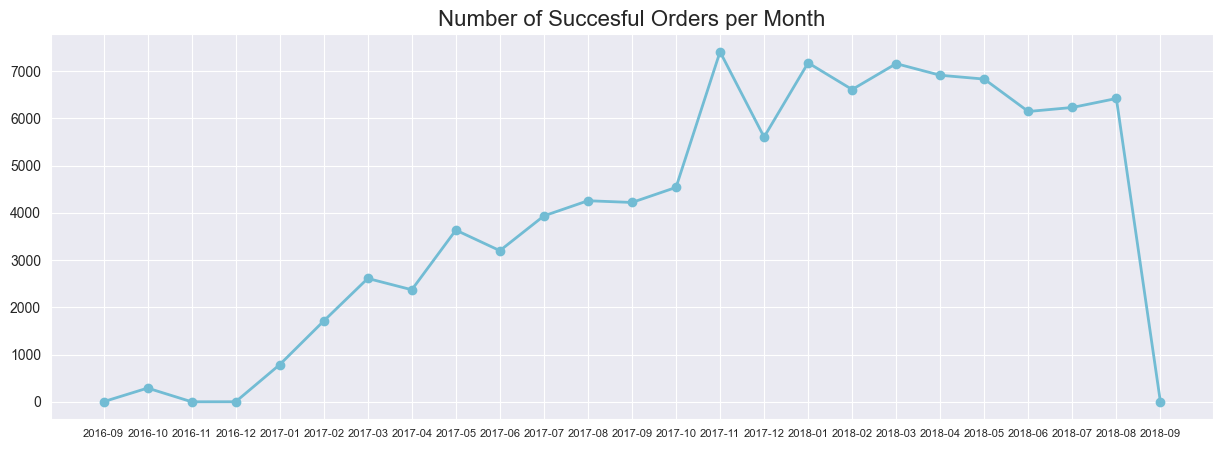

In [160]:
plt.figure(figsize=(15, 5)) 
plt.plot(all_monthly_orders_summary["order_year_month"], all_monthly_orders_summary["successful_order_count"], marker='o', linewidth=2, color="#72BCD4") 
plt.title("Number of Succesful Orders per Month", loc="center", fontsize=16) 
plt.xticks(fontsize=8) 
plt.yticks(fontsize=10) 
plt.show()

Jumlah order semakin meningkat hingga puncaknya di bulan November 2017 dan secara fluktuatif tetap berada di sekitar 6000-7000 order hingga bulan Agustus 2018.

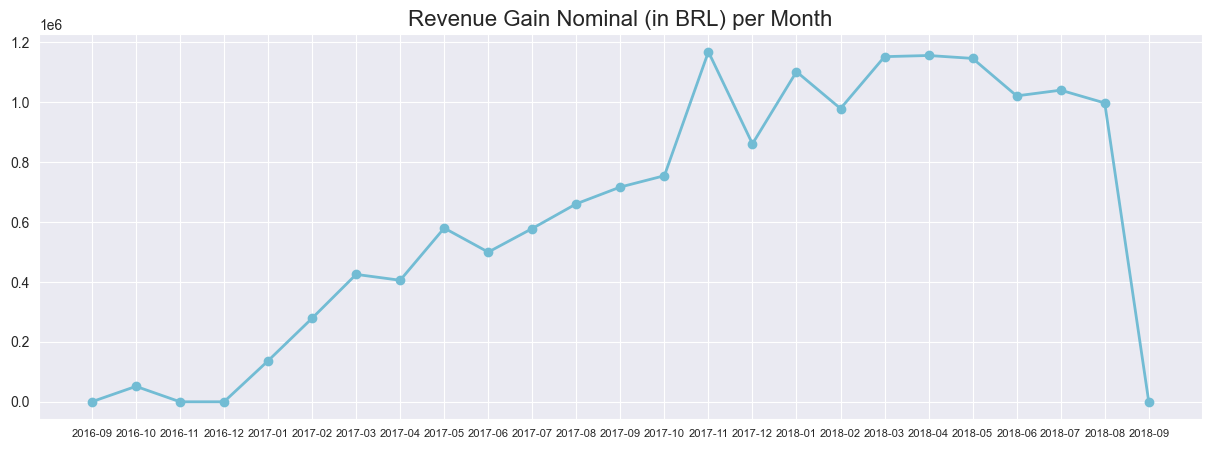

In [161]:
plt.figure(figsize=(15, 5)) 
plt.plot(all_monthly_orders_summary["order_year_month"], all_monthly_orders_summary["revenue_gain"], marker='o', linewidth=2, color="#72BCD4") 
plt.title("Revenue Gain Nominal (in BRL) per Month", loc="center", fontsize=16) 
plt.xticks(fontsize=8) 
plt.yticks(fontsize=10) 
plt.show()

Jumlah nominal transaksi sebanding dengan peningkatan dan penurunan order yang terjadi.

### Pertanyaan 2: Kategori Produk Apa yang Paling Banyak dan Paling Sedikit Penjualan Serta Revenuenya?

In [162]:
all_category_summary = all_successful_orders.groupby(['product_category_name_english', 'order_id', 'payment_sequential']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('payment_value', 'first')
).reset_index()

all_total_cat_summary = all_category_summary.groupby(['product_category_name_english']).agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('total_revenue', 'sum')
).reset_index()

all_total_cat_summary

,product_category_name_english,total_orders,total_revenue
0,agro_industry_and_commerce,182,78379.19
1,air_conditioning,253,62867.82
2,art,201,28764.33
3,arts_and_craftmanship,23,2241.54
4,audio,351,58540.11
...,...,...,...
68,stationery,2319,281845.15
69,tablets_printing_image,79,9217.91
70,telephony,4203,400476.75
71,toys,3990,587888.11


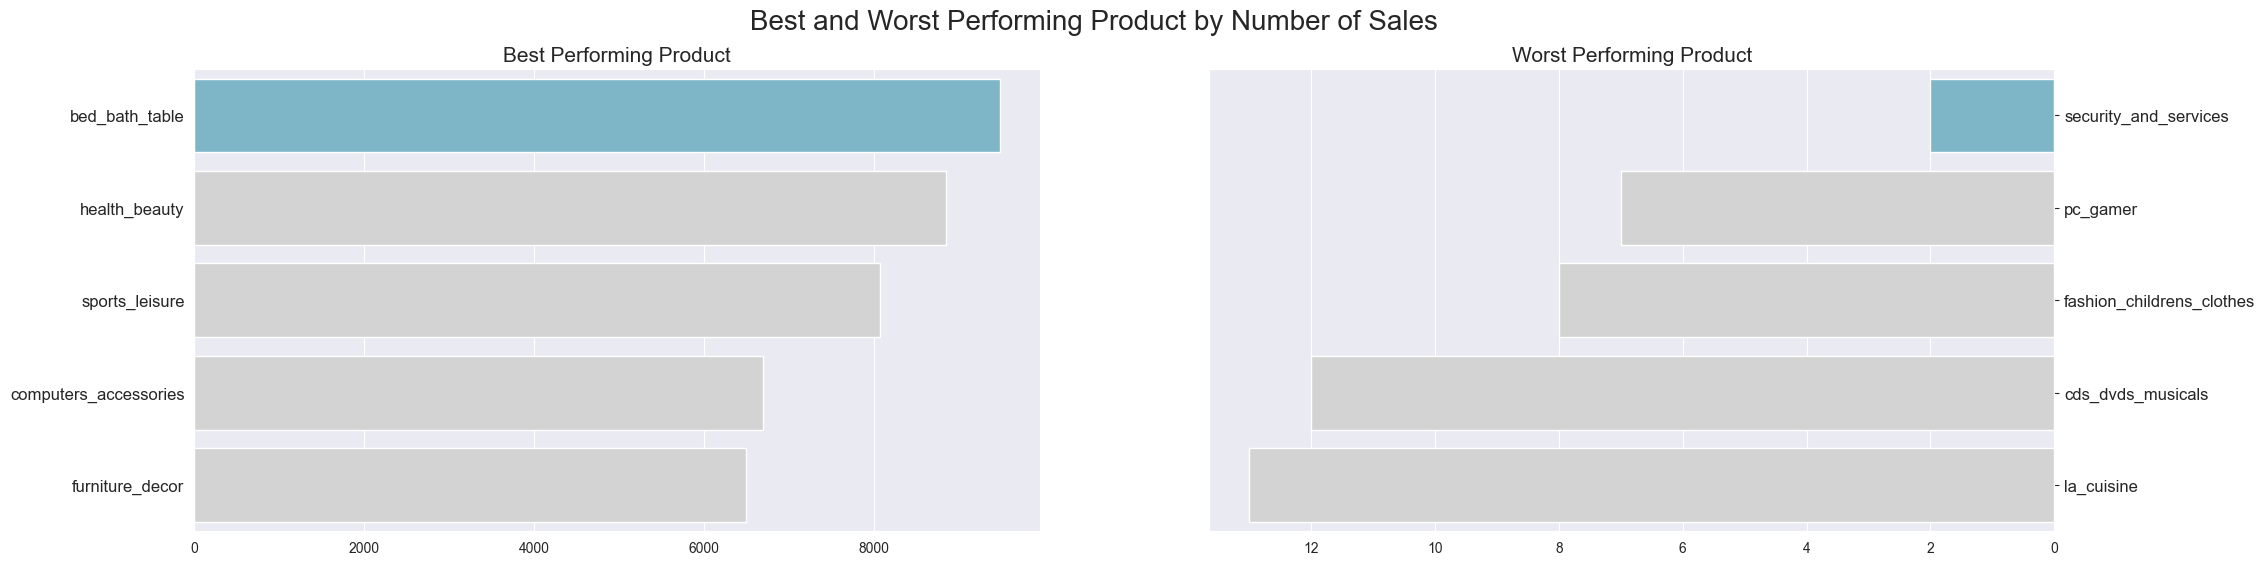

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
 
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
sns.barplot(x="total_orders", y="product_category_name_english", data=all_total_cat_summary.sort_values(by='total_orders', ascending=False).head(5), palette=colors, ax=ax[0], hue="product_category_name_english", legend=False)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)
 
sns.barplot(x="total_orders", y="product_category_name_english", data=all_total_cat_summary.sort_values(by='total_orders', ascending=True).head(5), palette=colors, ax=ax[1], hue="product_category_name_english", legend=False)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)
 
plt.suptitle("Best and Worst Performing Product by Number of Sales", fontsize=20)
plt.show()

Kategori produk bed_bath_table menjadi kategori produk dengan jumlah order paling banyak sekitar di atas 9000 orders dan kategori produk security_and_services menjadi kategori produk dengan jumlah order paling sedikit sejumlah 2 order.

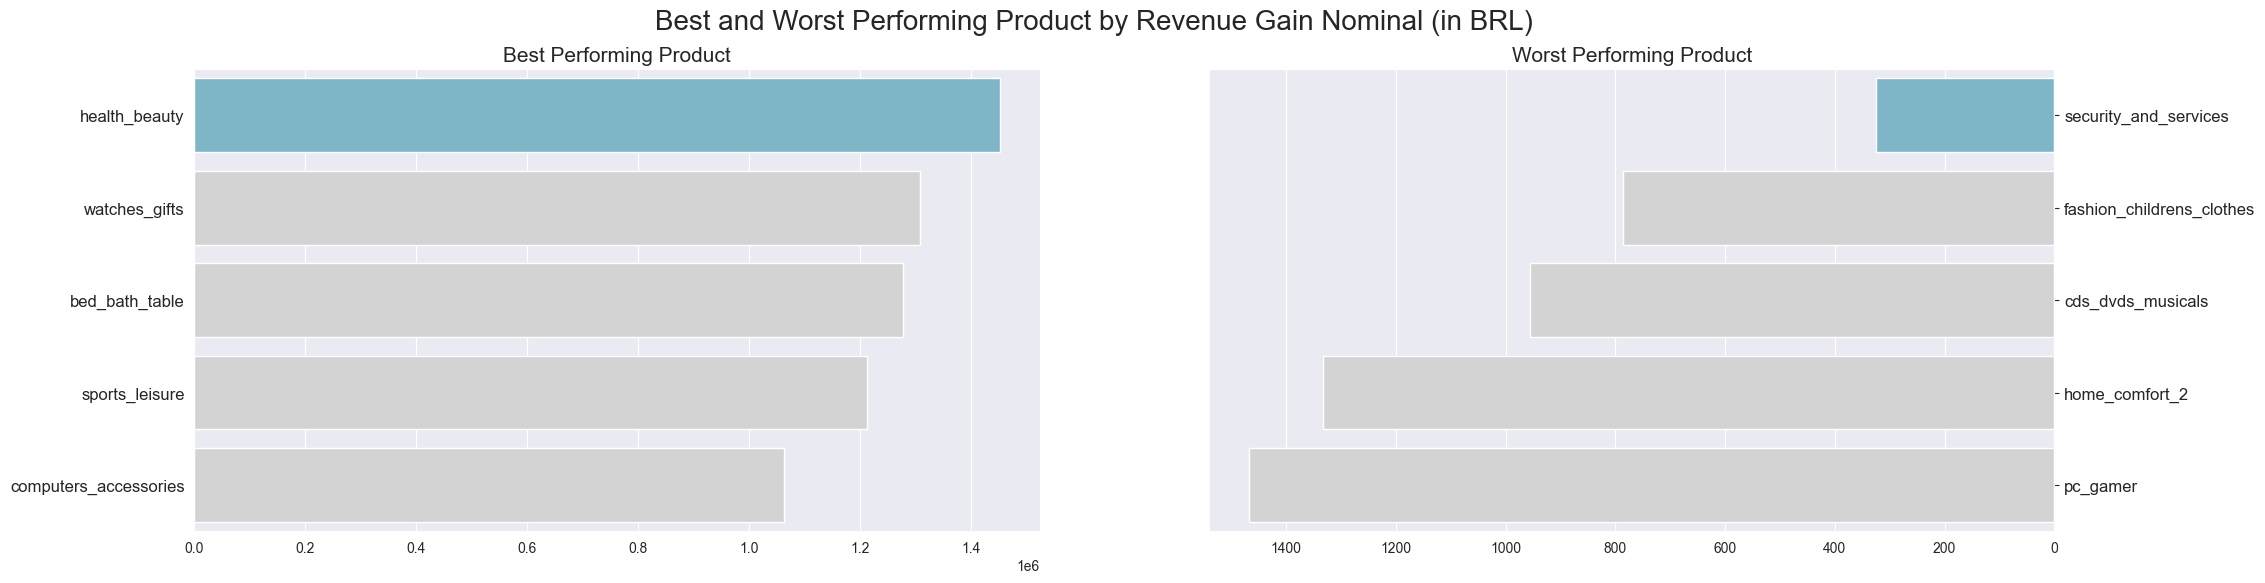

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
 
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
sns.barplot(x="total_revenue", y="product_category_name_english", data=all_total_cat_summary.sort_values(by='total_revenue', ascending=False).head(5), palette=colors, ax=ax[0], hue="product_category_name_english", legend=False)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)
 
sns.barplot(x="total_revenue", y="product_category_name_english", data=all_total_cat_summary.sort_values(by='total_revenue', ascending=True).head(5), palette=colors, ax=ax[1], hue="product_category_name_english", legend=False)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)
 
plt.suptitle("Best and Worst Performing Product by Revenue Gain Nominal (in BRL)", fontsize=20)
plt.show()

Kategori produk health_beauty menjadi kategori produk dengan nominal revenue paling banyak sekitar di atas BRL1,4juta dan kategori produk security_and_services menjadi kategori produk dengan nominal revenue paling sedikit di bawah BRL400.

### Pertanyaan 3: Bagaimana Ketepatan Waktu Delivery Kurir dengan Waktu Estimasinya?

In [165]:
all_delivered_orders = all_successful_orders.loc[(all_successful_orders['order_delivered_customer_date'].isna() == False)]

all_delivered_orders = all_delivered_orders.copy()

all_delivered_orders['delivery_estimation_difference'] = (all_delivered_orders['order_delivered_customer_date'] - all_delivered_orders['order_estimated_delivery_date']).dt.days

all_delivery_performance = all_delivered_orders.groupby('order_id').agg(
    delivered_date=('order_delivered_customer_date', 'first'),
    estimated_date=('order_estimated_delivery_date', 'first'),
    delivery_estimation_diff=('delivery_estimation_difference', 'first')
).reset_index()

all_delivery_performance

,order_id,delivered_date,estimated_date,delivery_estimation_diff
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,2017-09-29,-9
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,2017-05-15,-3
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,2018-02-05,-14
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,2018-08-20,-6
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,2017-03-17,-16
...,...,...,...,...
96323,fffc94f6ce00a00581880bf54a75a037,2018-05-10 22:56:40,2018-05-18,-8
96324,fffcd46ef2263f404302a634eb57f7eb,2018-07-23 20:31:55,2018-08-01,-9
96325,fffce4705a9662cd70adb13d4a31832d,2017-10-28 12:22:22,2017-11-10,-13
96326,fffe18544ffabc95dfada21779c9644f,2017-08-16 21:59:40,2017-08-25,-9


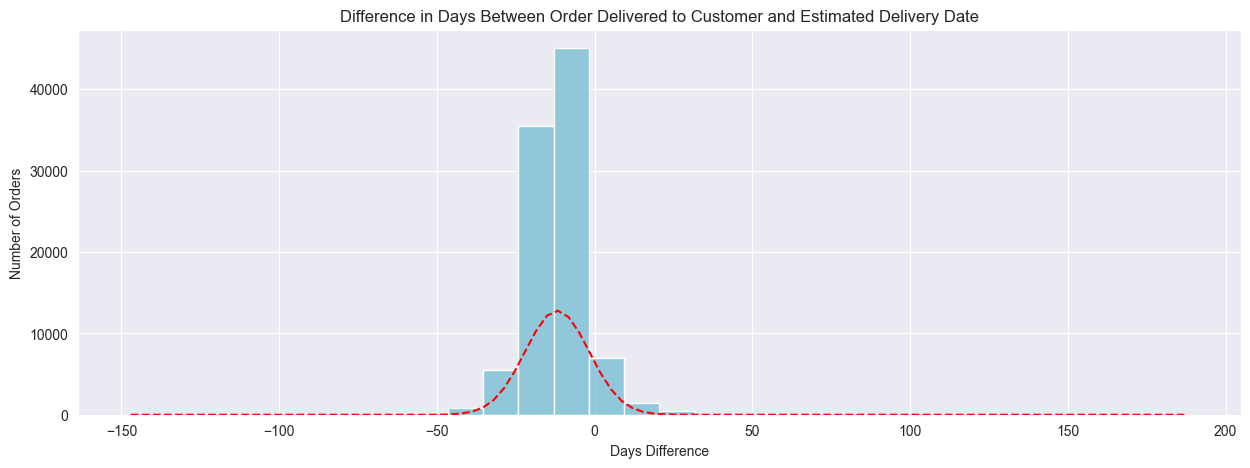

In [166]:
plt.figure(figsize=(15, 5))
sns.histplot(all_delivery_performance['delivery_estimation_diff'], bins=30, color="#72BCD4")
plt.title('Difference in Days Between Order Delivered to Customer and Estimated Delivery Date')
plt.xlabel('Days Difference')
plt.ylabel('Number of Orders')

# Add a curve belt line
mean = all_delivery_performance['delivery_estimation_diff'].mean()
std = all_delivery_performance['delivery_estimation_diff'].std()
x = np.linspace(all_delivery_performance['delivery_estimation_diff'].min(), all_delivery_performance['delivery_estimation_diff'].max(), 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p * len(all_delivery_performance['delivery_estimation_diff']) * (x[1] - x[0]), 'r--')

plt.show()

Distribusi normal dari selisih waktu riil pengiriman kurir dan waktu estimasinya menunjukkan mayoritas setidaknya 80% pesanan sampai ke customer sebelum waktu estimasi.

### Pertanyaan 4: Bagaimana Ketepatan Waktu Shipping Penjual dengan Batas Waktunya?

In [167]:
all_shipped_orders = all_successful_orders.loc[(all_successful_orders['order_delivered_carrier_date'].isna() == False)]

all_shipped_orders = all_shipped_orders.copy()

all_shipped_orders['shipping_limit_difference'] = (all_shipped_orders['order_delivered_carrier_date'] - all_shipped_orders['shipping_limit_date']).dt.days

all_shipment_performance = all_shipped_orders.groupby('order_id').agg(
    shipped_date=('order_delivered_carrier_date', 'first'),
    limit_date=('shipping_limit_date', 'first'),
    shipment_limit_diff=('shipping_limit_difference', 'first')
).reset_index()

all_shipment_performance

,order_id,shipped_date,limit_date,shipment_limit_diff
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 18:34:16,2017-09-19 09:45:35,0
1,00018f77f2f0320c557190d7a144bdd3,2017-05-04 14:35:00,2017-05-03 11:05:13,1
2,000229ec398224ef6ca0657da4fc703e,2018-01-16 12:36:48,2018-01-18 14:48:30,-3
3,00024acbcdf0a6daa1e931b038114c75,2018-08-10 13:28:00,2018-08-15 10:10:18,-5
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-16 09:46:09,2017-02-13 13:57:51,2
...,...,...,...,...
97433,fffc94f6ce00a00581880bf54a75a037,2018-04-25 12:09:00,2018-05-02 04:11:01,-7
97434,fffcd46ef2263f404302a634eb57f7eb,2018-07-17 08:05:00,2018-07-20 04:31:48,-3
97435,fffce4705a9662cd70adb13d4a31832d,2017-10-26 15:13:14,2017-10-30 17:14:25,-5
97436,fffe18544ffabc95dfada21779c9644f,2017-08-15 19:02:53,2017-08-21 00:04:32,-6


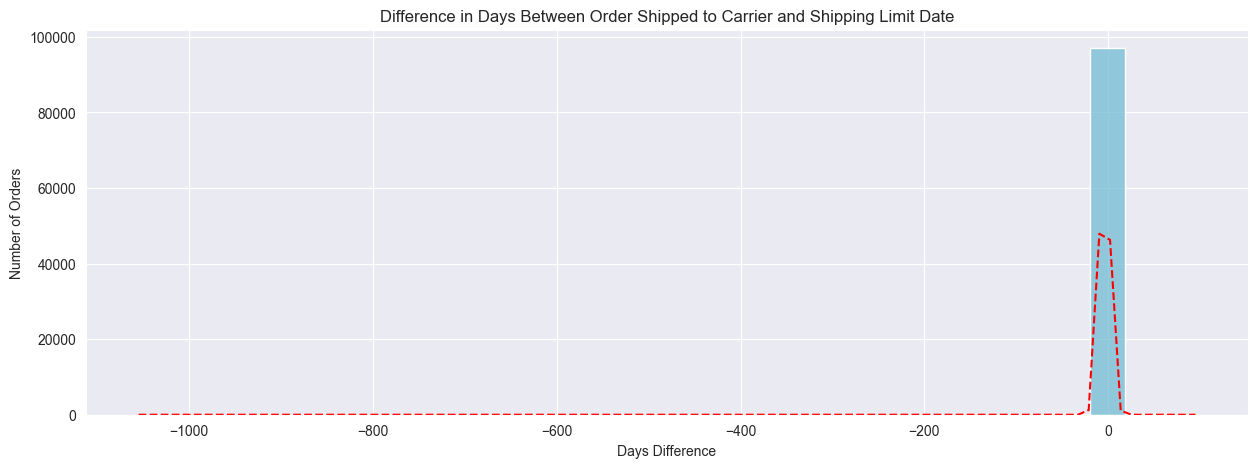

In [168]:
plt.figure(figsize=(15, 5))
sns.histplot(all_shipment_performance['shipment_limit_diff'], bins=30, color="#72BCD4")
plt.title('Difference in Days Between Order Shipped to Carrier and Shipping Limit Date')
plt.xlabel('Days Difference')
plt.ylabel('Number of Orders')

# Add a curve belt line
mean = all_shipment_performance['shipment_limit_diff'].mean()
std = all_shipment_performance['shipment_limit_diff'].std()
x = np.linspace(all_shipment_performance['shipment_limit_diff'].min(), all_shipment_performance['shipment_limit_diff'].max(), 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p * len(all_shipment_performance['shipment_limit_diff']) * (x[1] - x[0]), 'r--')

plt.show()

Distribusi normal dari selisih waktu riil pemrosesan seller dan batas waktunya menunjukkan mayoritas setidaknya 80% pesanan diproses ke kurir sebelum batas waktunya.

### Pertanyaan 5: Bagaimana Persebaran Lokasi Penjual dan Hasil Penjualannya?

In [169]:
all_sellers_order_count_state = all_successful_orders.groupby('seller_state').agg(
    order_count=('order_id', 'nunique')
).reset_index()

all_sellers_order_count_state

,seller_state,order_count
0,AC,1
1,AM,3
2,BA,567
3,CE,90
4,DF,821
5,ES,317
6,GO,450
7,MA,392
8,MG,7855
9,MS,49


In [170]:
# Get the list of states that are not present in the current grouped data
seller_missing_states = geolocation_df[~geolocation_df['geolocation_state'].isin(all_sellers_order_count_state['seller_state'])]

seller_missing_states_df = pd.DataFrame({
    'seller_state': seller_missing_states['geolocation_state'].unique(),
    'order_count': 0
})
all_sellers_order_count_state = pd.concat([all_sellers_order_count_state, seller_missing_states_df], ignore_index=True)

all_sellers_order_count_state

,seller_state,order_count
0,AC,1
1,AM,3
2,BA,567
3,CE,90
4,DF,821
5,ES,317
6,GO,450
7,MA,392
8,MG,7855
9,MS,49


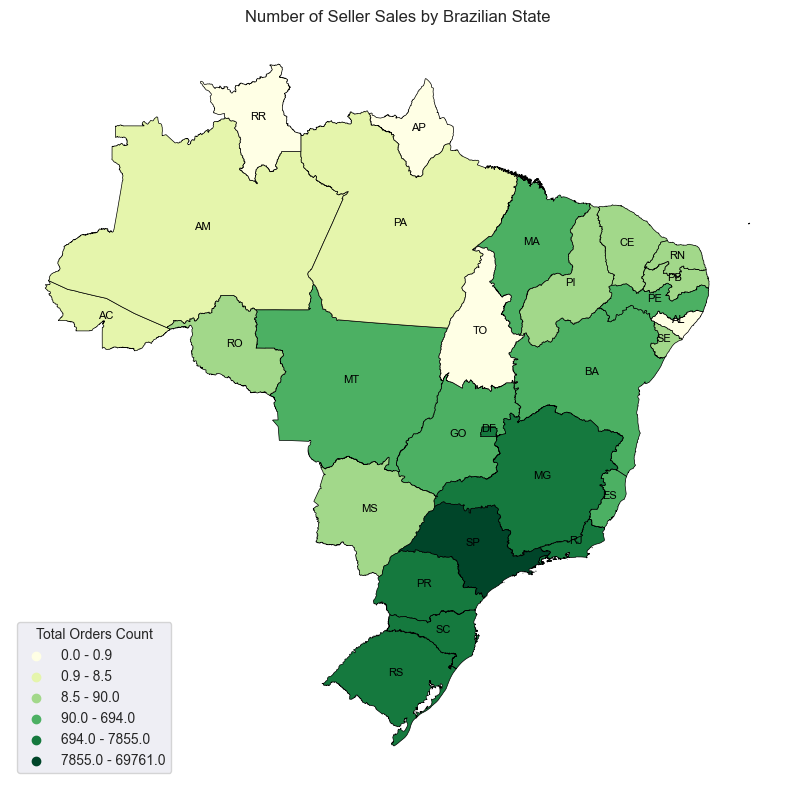

In [171]:
# Load GeoJSON data into a GeoDataFrame
geojson_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(geojson_url)

# Calculate quantiles for order_count
quantiles = all_sellers_order_count_state['order_count'].quantile([0.25, 0.50, 0.75]).tolist()

# Find the index of value after the minimum value
asc_sorted = all_sellers_order_count_state.sort_values(by='order_count', ascending=True)
min_value = all_sellers_order_count_state['order_count'].min()
idx_last_min_val = asc_sorted.loc[all_sellers_order_count_state['order_count'] == min_value]['seller_state'].nunique()

# Find the index of value before the maximum value
max_value = all_sellers_order_count_state['order_count'].max()
idx_last_max_val = (-1) - asc_sorted.loc[all_sellers_order_count_state['order_count'] == max_value]['seller_state'].nunique()

# Create 1 bin for the min value, 1 bin for the max value, and 4 bins for the rest of quantile
bins = [min_value, asc_sorted.iloc[idx_last_min_val]['order_count'] - 0.1] + quantiles + [asc_sorted.iloc[idx_last_max_val]['order_count'], max_value]
num_categories = len(bins) - 1

# Assign bins for color mapping
all_sellers_order_count_state['bin'] = pd.cut(
    all_sellers_order_count_state['order_count'],
    bins=bins,
    labels=False,
    include_lowest=True
)

# Merge GeoDataFrame for plotting
gdf = gdf.merge(all_sellers_order_count_state, left_on='sigla', right_on='seller_state')

# Define a color map
cmap = plt.cm.YlGn  # Matplotlib colormap
colors = cmap(np.linspace(0, 1, num_categories))  # Generate color steps
color_mapping = {i: colors[i] for i in range(num_categories)}  # Map bins to colors
gdf['color'] = gdf['bin'].map(color_mapping)

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', linewidth=0.5)

# Add state names to the map
for idx, row in gdf.iterrows():
    plt.annotate(text=row['sigla'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Add a legend
legend_labels = [f"{bins[i]:.1f} - {bins[i+1]:.1f}" for i in range(num_categories)]
for i, label in enumerate(legend_labels):
    ax.scatter([], [], color=colors[i], label=label)

ax.legend(loc='lower left', title="Total Orders Count")
ax.set_title("Number of Seller Sales by Brazilian State")
plt.axis("off")

plt.show()

State SP menjadi state penjual dengan jumlah order kolektif paling banyak sejumlah 69.761 orders. Sedangkan state AP, RR, TO, dan AL menjadi state penjual dengan jumlah order kolektif paling sedikit sejumlah 0 order.

### Pertanyaan 6: Bagaimana Persebaran Rating Penjual?

In [172]:
all_sellers_rating = all_successful_orders.groupby('seller_id').agg(
    order_count=("order_id", "nunique"),
    average_rating=("review_score", "mean")
).reset_index()

all_rating_below_2 = all_sellers_rating.loc[(all_sellers_rating['average_rating'] >= 1) & (all_sellers_rating['average_rating'] < 2)]
n_all_rating_below_2 = all_rating_below_2['seller_id'].nunique()

all_rating_below_3 = all_sellers_rating.loc[(all_sellers_rating['average_rating'] >= 2) & (all_sellers_rating['average_rating'] < 3)]
n_all_rating_below_3 = all_rating_below_3['seller_id'].nunique()

all_rating_below_4 = all_sellers_rating.loc[(all_sellers_rating['average_rating'] >= 3) & (all_sellers_rating['average_rating'] < 4)]
n_all_rating_below_4 = all_rating_below_4['seller_id'].nunique()

all_rating_below_5 = all_sellers_rating.loc[(all_sellers_rating['average_rating'] >= 4) & (all_sellers_rating['average_rating'] < 5)]
n_all_rating_below_5 = all_rating_below_5['seller_id'].nunique()

all_rating_perfect = all_sellers_rating.loc[(all_sellers_rating['average_rating'] == 5)]
n_all_rating_perfect = all_rating_perfect['seller_id'].nunique()

all_sellers_rating

,seller_id,order_count,average_rating
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,200,3.911765
2,002100f778ceb8431b7a1020ff7ab48f,51,4.033898
3,004c9cd9d87a3c30c522c48c4fc07416,158,4.101942
4,00720abe85ba0859807595bbf045a33b,13,3.653846
...,...,...,...
2989,ffc470761de7d0232558ba5e786e57b7,28,4.281250
2990,ffdd9f82b9a447f6f8d4b91554cc7dd3,18,4.285714
2991,ffeee66ac5d5a62fe688b9d26f83f534,14,4.214286
2992,fffd5413c0700ac820c7069d66d98c89,59,3.866667


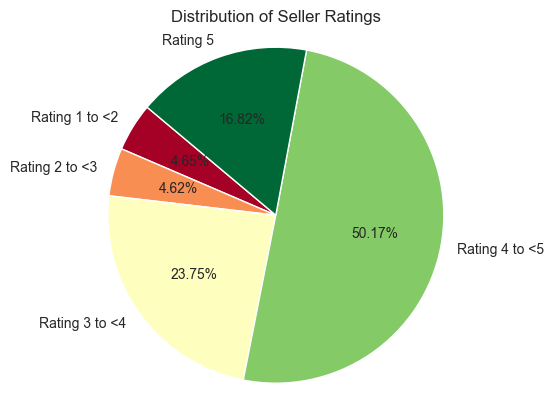

In [173]:
labels = ['Rating 1 to <2', 'Rating 2 to <3', 'Rating 3 to <4', 'Rating 4 to <5', 'Rating 5']
sizes = [n_all_rating_below_2,
         n_all_rating_below_3,
         n_all_rating_below_4,
         n_all_rating_below_5,
         n_all_rating_perfect]

# Pie chart colormap
cmap = plt.cm.RdYlGn
colors = cmap(np.linspace(0, 1, len(sizes)))

plt.pie(sizes,
        labels=labels,
        colors=colors,
        autopct='%1.2f%%',
        shadow=False,
        startangle=140)

plt.axis('equal')  
plt.title('Distribution of Seller Ratings')
plt.show()

Mayoritas seller sebanyak 50,17% memiliki rating di antara 4 (inklusif) sampai 5. Diikuti rating 3-4 sebanyak 23,75%, rating 5 sebanyak 16,82%, rating 1-2 sebanyak 4,65%, dan rating 2-3 sebanyak 4,62%.

### Pertanyaan 7: Bagaimana Persebaran Lokasi Pelanggan dan Total Pembeliannya?

In [174]:
all_customers_order_count_state = all_successful_orders.groupby('customer_state').agg(
    order_count=('order_id', 'nunique')
).reset_index()

all_customers_order_count_state

,customer_state,order_count
0,AC,81
1,AL,410
2,AM,147
3,AP,68
4,BA,3338
5,CE,1322
6,DF,2118
7,ES,2018
8,GO,1990
9,MA,735


In [175]:
# Get the list of states that are not present in the current grouped data
customer_missing_states = geolocation_df[~geolocation_df['geolocation_state'].isin(all_customers_order_count_state['customer_state'])]

customer_missing_states_df = pd.DataFrame({
    'customer_state': customer_missing_states['geolocation_state'].unique(),
    'order_count': 0
})
all_customers_order_count_state = pd.concat([all_customers_order_count_state, customer_missing_states_df], ignore_index=True)

all_customers_order_count_state

,customer_state,order_count
0,AC,81
1,AL,410
2,AM,147
3,AP,68
4,BA,3338
5,CE,1322
6,DF,2118
7,ES,2018
8,GO,1990
9,MA,735


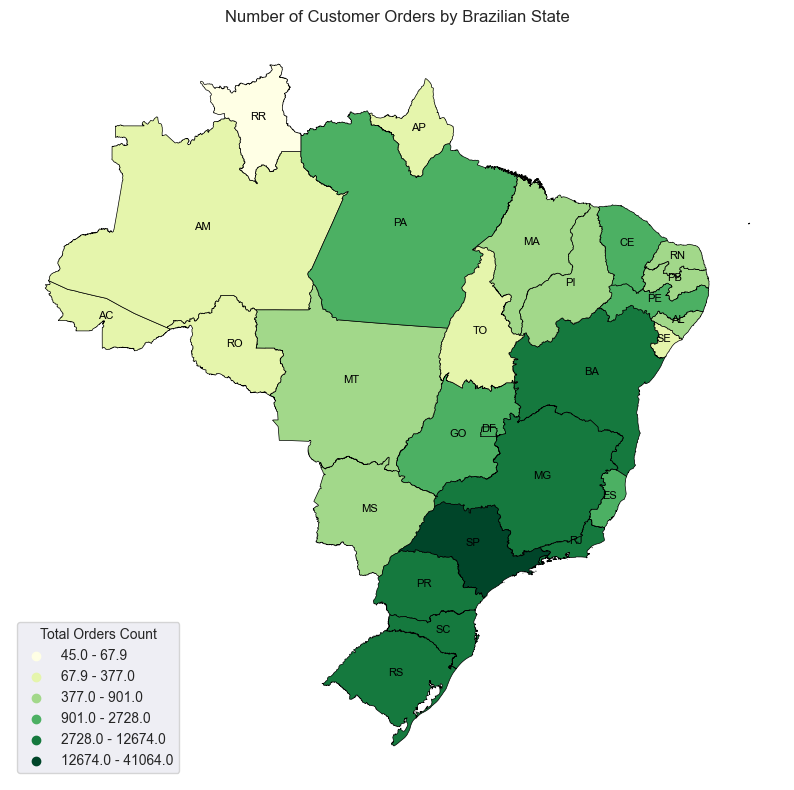

In [176]:
# Load GeoJSON data into a GeoDataFrame
geojson_url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(geojson_url)

# Calculate quantiles for order_count
quantiles = all_customers_order_count_state['order_count'].quantile([0.25, 0.50, 0.75]).tolist()

# Find the index of value after the minimum value
asc_sorted = all_customers_order_count_state.sort_values(by='order_count', ascending=True)
min_value = all_customers_order_count_state['order_count'].min()
idx_last_min_val = asc_sorted.loc[all_customers_order_count_state['order_count'] == min_value]['customer_state'].nunique()

# Find the index of value before the maximum value
max_value = all_customers_order_count_state['order_count'].max()
idx_last_max_val = (-1) - asc_sorted.loc[all_customers_order_count_state['order_count'] == max_value]['customer_state'].nunique()

# Create 1 bin for the min value, 1 bin for the max value, and 4 bins for the rest of quantile
bins = [min_value, asc_sorted.iloc[idx_last_min_val]['order_count'] - 0.1] + quantiles + [asc_sorted.iloc[idx_last_max_val]['order_count'], max_value]
num_categories = len(bins) - 1

# Assign bins for color mapping
all_customers_order_count_state['bin'] = pd.cut(
    all_customers_order_count_state['order_count'],
    bins=bins,
    labels=False,
    include_lowest=True
)

# Merge GeoDataFrame for plotting
gdf = gdf.merge(all_customers_order_count_state, left_on='sigla', right_on='customer_state')

# Define a color map
cmap = plt.cm.YlGn  # Matplotlib colormap
colors = cmap(np.linspace(0, 1, num_categories))  # Generate color steps
color_mapping = {i: colors[i] for i in range(num_categories)}  # Map bins to colors
gdf['color'] = gdf['bin'].map(color_mapping)

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', linewidth=0.5)

# Add state names to the map
for idx, row in gdf.iterrows():
    plt.annotate(text=row['sigla'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Add a legend
legend_labels = [f"{bins[i]:.1f} - {bins[i+1]:.1f}" for i in range(num_categories)]
for i, label in enumerate(legend_labels):
    ax.scatter([], [], color=colors[i], label=label)

ax.legend(loc='lower left', title="Total Orders Count")
ax.set_title("Number of Customer Orders by Brazilian State")
plt.axis("off")

plt.show()

State SP menjadi state pelanggan dengan jumlah order kolektif paling banyak sejumlah 41.064 orders. Sedangkan state RR menjadi state pelanggan dengan jumlah order kolektif paling sedikit sejumlah 45 order.

### Pertanyaan 8: Bagaimana Preferensi Pelanggan dalam Melakukan Pembayaran Transaksi?

In [177]:
# Group by payment sequential, so the payment_value is not duplicated
all_successful_payment = all_successful_orders.groupby(['payment_type', 'order_id', 'payment_sequential']).agg({
    'payment_value': 'first'
}).reset_index()

all_payment_avg = all_successful_payment.groupby('payment_type').agg(
    payment_count=('payment_type', 'count'),
    payment_value=('payment_value', 'sum')
).reset_index()

all_payment_avg['average_value'] = round(all_payment_avg['payment_value'] / all_payment_avg['payment_count'], 2)

all_payment_avg.sort_values(by='average_value', ascending=False)

,payment_type,payment_count,payment_value,average_value
1,credit_card,75780,12319630.28,162.57
0,boleto,19507,2821063.02,144.62
2,debit_card,1515,212303.98,140.13
3,voucher,5606,349141.18,62.28


In [178]:
n_all_boleto = ((all_payment_avg.loc[all_payment_avg['payment_type'] == 'boleto']['payment_count'].values[0] * 100) / (all_payment_avg['payment_count'].sum()))

n_all_cc = ((all_payment_avg.loc[all_payment_avg['payment_type'] == 'credit_card']['payment_count'].values[0] * 100) / (all_payment_avg['payment_count'].sum()))

n_all_dc = ((all_payment_avg.loc[all_payment_avg['payment_type'] == 'debit_card']['payment_count'].values[0] * 100) / (all_payment_avg['payment_count'].sum()))

n_all_voucher = ((all_payment_avg.loc[all_payment_avg['payment_type'] == 'voucher']['payment_count'].values[0] * 100) / (all_payment_avg['payment_count'].sum()))

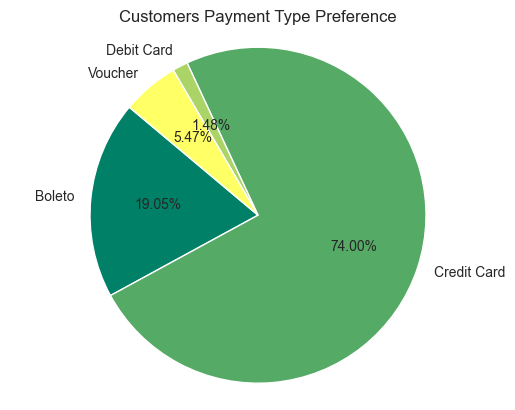

In [179]:
labels = ['Boleto', 'Credit Card', 'Debit Card', 'Voucher']
sizes = [n_all_boleto,
         n_all_cc,
         n_all_dc,
         n_all_voucher]

# Pie chart colormap
cmap = plt.cm.summer
colors = cmap(np.linspace(0, 1, len(sizes)))

plt.pie(sizes,
        labels=labels,
        colors=colors,
        autopct='%1.2f%%',
        shadow=False,
        startangle=140)

plt.axis('equal')  
plt.title('Customers Payment Type Preference')
plt.show()

Mayoritas pelanggan memilih credit card sebagai alat pembayaran sebanyak 74,00% transaksi. Diikuti boleto sebanyak 19,05% transaksi, voucher sebanyak 5,47%, dan debit card sebanyak 1,48%.

### Pertanyaan 9: Kapan terakhir pelanggan melakukan transaksi? Seberapa sering seorang pelanggan melakukan pembelian dalam beberapa bulan terakhir? Berapa banyak uang yang dihabiskan pelanggan dalam beberapa bulan terakhir?

In [180]:
# Group by payment sequential, so the payment_value is not duplicated
all_successful_payment = all_successful_orders.groupby(['customer_unique_id', 'order_purchase_timestamp', 'order_id', 'payment_sequential']).agg({
    'payment_value': 'first'
}).reset_index()

all_rfm_df = all_successful_payment.groupby(by='customer_unique_id', as_index=False).agg(
    recent_order_date=('order_purchase_timestamp', 'max'), # mengambil tanggal order terakhir
    frequency=('order_id', 'nunique'), # menghitung jumlah order
    monetary=('payment_value', 'sum') # menghitung jumlah revenue yang dihasilkan
)
 
# menghitung kapan terakhir pelanggan melakukan transaksi (hari)
all_rfm_df['recent_order_date'] = all_rfm_df['recent_order_date'].dt.date
all_recent_date = all_successful_orders['order_purchase_timestamp'].dt.date.max()
all_rfm_df['recency'] = all_rfm_df['recent_order_date'].apply(lambda x: (all_recent_date - x).days)
 
all_rfm_df.drop('recent_order_date', axis=1, inplace=True)
all_rfm_df.head()

,customer_unique_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119
2,0000f46a3911fa3c0805444483337064,1,86.22,542
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293


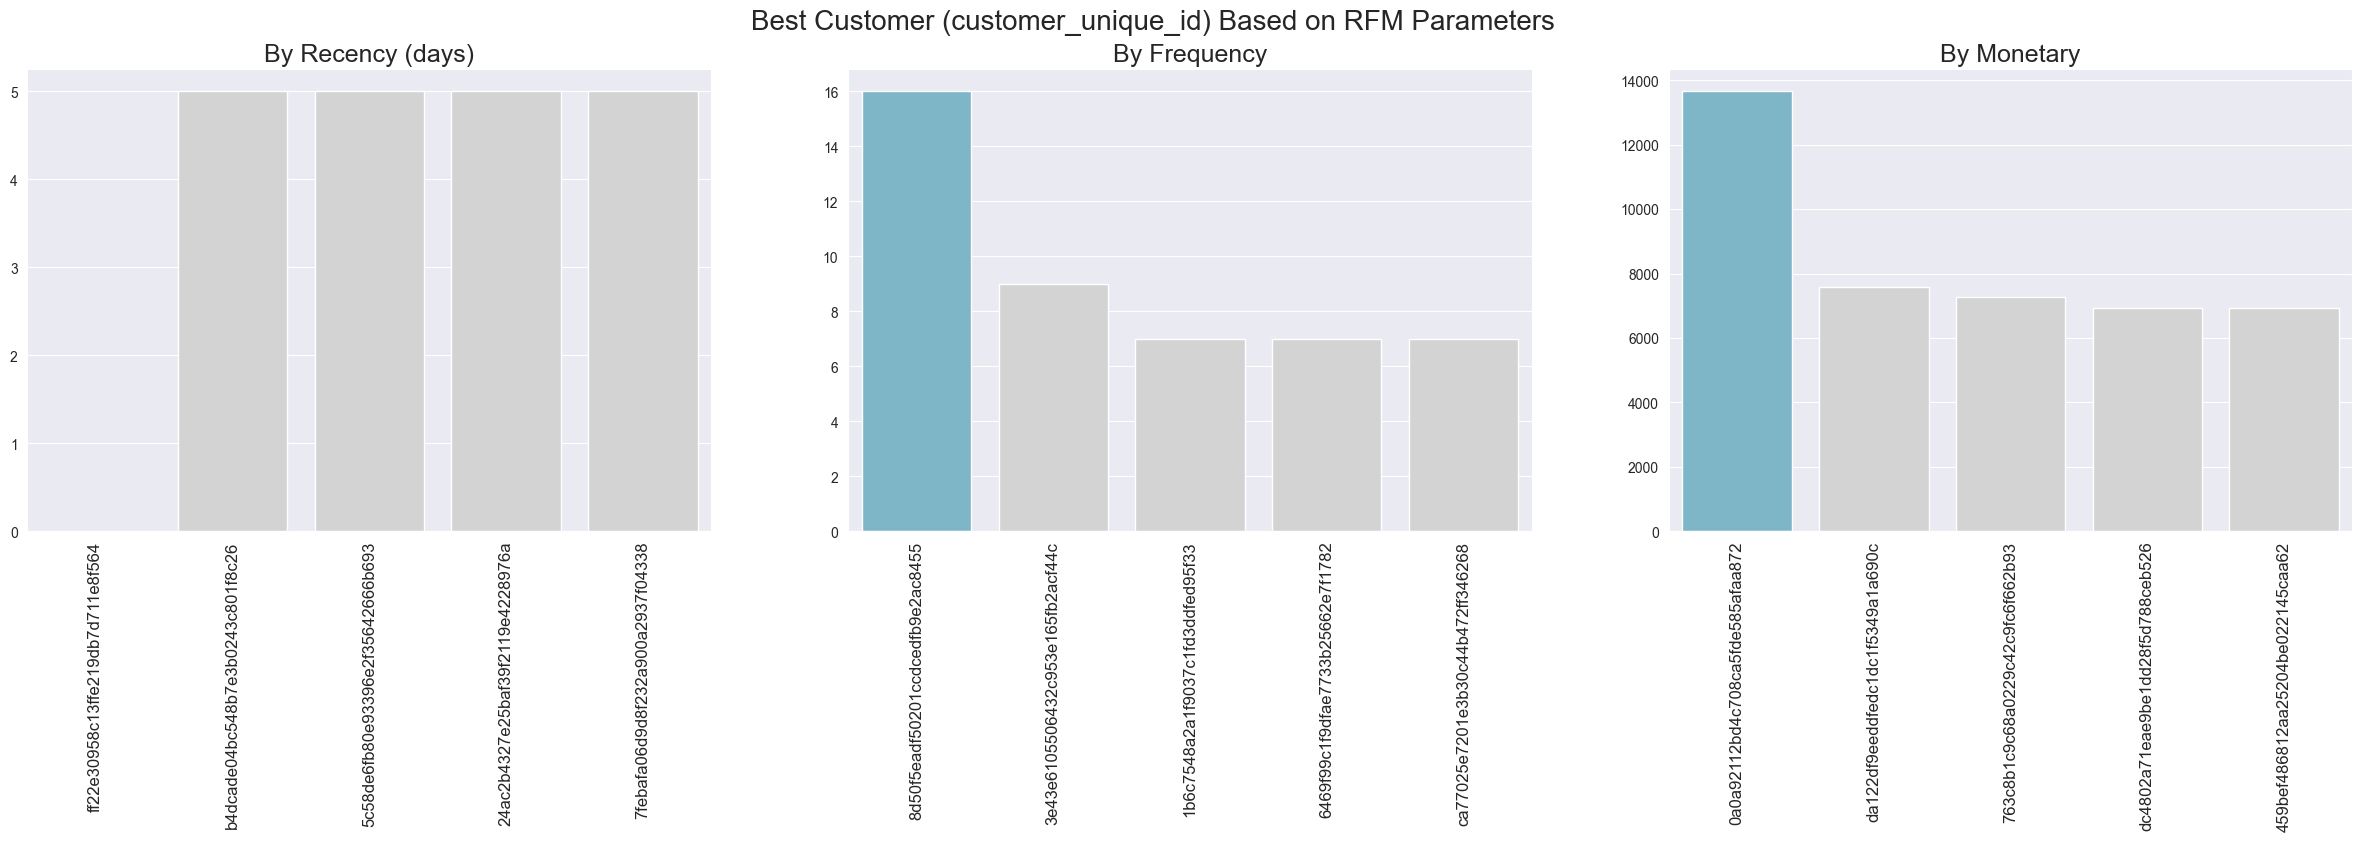

In [181]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))
 
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
sns.barplot(y="recency", x="customer_unique_id", data=all_rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0], hue="customer_unique_id", legend=False)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=12,rotation=90)
 
sns.barplot(y="frequency", x="customer_unique_id", data=all_rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1], hue="customer_unique_id", legend=False)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=12, rotation=90)
 
sns.barplot(y="monetary", x="customer_unique_id", data=all_rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2], hue="customer_unique_id", legend=False)
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=12, rotation=90)
 
plt.suptitle("Best Customer (customer_unique_id) Based on RFM Parameters", fontsize=20)
plt.show()

Pelanggan terbaik berdasarkan transaksinya terakhir kali melakukan transaksi 0 hari dari hari terakhir dataset dan diikuti pelanggan lainnya yang melakukan transaksi 5 hari sebelumnya. Pelanggan terbaik berdasarkan frekuensi pembelian melakukan 16 kali transaksi dan diikuti pelanggan lainnya yang melakukan 9 kali, 7 kali, dan seterusnya. Pelanggan terbaik berdasarkan jumlah uang yang dihabiskan telah mengeluarkan hampir BRL14.000,00 dan diikuti pelanggan lainnya yang mengeluarkan uang di bawah BRL8.000,00.

### Pertanyaan 10: Bagaimana Persebaran Kelompok Pelanggan Berdasarkan Frekuensi Pembelian dan Nominal Transaksi?

In [182]:
all_rfm_df['avg_monetary'] = round(all_rfm_df['monetary'] / all_rfm_df['frequency'], 2)

all_rfm_df.head()

,customer_unique_id,frequency,monetary,recency,avg_monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119,27.19
2,0000f46a3911fa3c0805444483337064,1,86.22,542,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293,196.89


In [183]:
# Binning/manual clustering kolom frequency dan average monetary
# Batas bawah dikurangi 1 (-1) untuk memastikan seluruh nilai termasuk di dalam cluster.
# Statistik kolom diperiksa, jika nilai median sama dengan nilai maksimum, maka hanya bisa menggunakan 1 bin
freq_bins = [all_rfm_df['frequency'].min() - 1, all_rfm_df['frequency'].median(), all_rfm_df['frequency'].max()] if (all_rfm_df['frequency'].median() != all_rfm_df['frequency'].max()) else [all_rfm_df['frequency'].min() - 1, all_rfm_df['frequency'].max()]
avg_mon_bins = [all_rfm_df['avg_monetary'].min() - 1, all_rfm_df['avg_monetary'].median(), all_rfm_df['avg_monetary'].max()] if (all_rfm_df['avg_monetary'].median() != all_rfm_df['avg_monetary'].max()) else [all_rfm_df['avg_monetary'].min() - 1, all_rfm_df['avg_monetary'].max()]

freq_labels = ['Low Frequency', 'High Frequency'] if (all_rfm_df['frequency'].median() != all_rfm_df['frequency'].max()) else ['Low Frequency']
mon_labels = ['Low Monetary', 'High Monetary'] if (all_rfm_df['avg_monetary'].median() != all_rfm_df['avg_monetary'].max()) else ['Low Monetary']

all_rfm_df['frequency_bin'] = pd.cut(all_rfm_df['frequency'], bins=freq_bins, labels=freq_labels)
all_rfm_df['monetary_bin'] = pd.cut(all_rfm_df['avg_monetary'], bins=avg_mon_bins, labels=mon_labels)

all_rfm_df.head()

,customer_unique_id,frequency,monetary,recency,avg_monetary,frequency_bin,monetary_bin
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116,141.90,Low Frequency,High Monetary
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119,27.19,Low Frequency,Low Monetary
2,0000f46a3911fa3c0805444483337064,1,86.22,542,86.22,Low Frequency,Low Monetary
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326,43.62,Low Frequency,Low Monetary
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293,196.89,Low Frequency,High Monetary


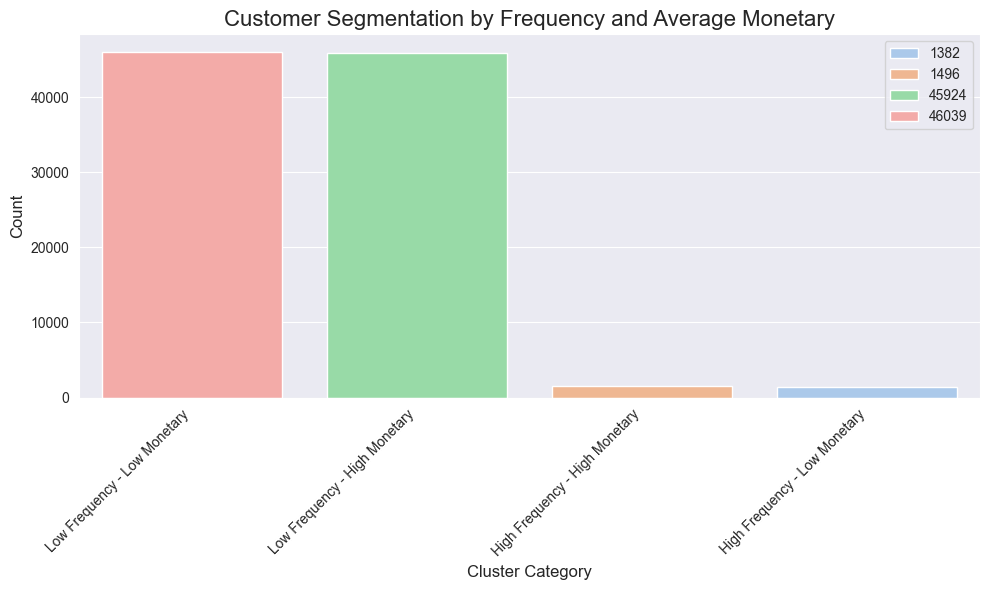

In [184]:
# Create a new column for combined categories
all_rfm_df['category'] = all_rfm_df['frequency_bin'].astype(str) + ' - ' + all_rfm_df['monetary_bin'].astype(str)
category_counts = all_rfm_df['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette=sns.color_palette("pastel", n_colors=len(category_counts)), hue=category_counts.values)
plt.title("Customer Segmentation by Frequency and Average Monetary", fontsize=16)
plt.xlabel("Cluster Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()

Mayoritas segmen pelanggan melakukan transaksi dengan jumlah yang sedikit, tetapi jumlahnya bervariasi antara pelanggan yang menghabiskan rata-rata uang sedikit dan banyak. Segmen pelanggan yang melakukan transaksi berulang dan frekuensinya tinggi jumlahnya tidak sebanyak segmen pelanggan sebelumnya, tetapi jumlahnya tetap bervariasi antara pelanggan yang menghabiskan rata-rata uang sedikit dan banyak.

## Conclusion

1. Jumlah order semakin meningkat hingga puncaknya di bulan November 2017 dan secara fluktuatif tetap berada di sekitar 6000-7000 order hingga bulan Agustus 2018. Jumlah nominal transaksi sebanding dengan peningkatan dan penurunan order yang terjadi.
2. Kategori produk bed_bath_table menjadi kategori produk dengan jumlah order paling banyak sekitar di atas 9000 orders dan kategori produk security_and_services menjadi kategori produk dengan jumlah order paling sedikit sejumlah 2 order. Kategori produk health_beauty menjadi kategori produk dengan nominal revenue paling banyak sekitar di atas BRL1,4juta dan kategori produk security_and_services menjadi kategori produk dengan nominal revenue paling sedikit di bawah BRL400.
3. Distribusi normal dari selisih waktu riil pengiriman kurir dan waktu estimasinya menunjukkan mayoritas setidaknya 80% pesanan sampai ke customer sebelum waktu estimasi.
4. Distribusi normal dari selisih waktu riil pemrosesan seller dan batas waktunya menunjukkan mayoritas setidaknya 80% pesanan diproses ke kurir sebelum batas waktunya.
5. State SP menjadi state penjual dengan jumlah order kolektif paling banyak sejumlah 69.761 orders. Sedangkan state AP, RR, TO, dan AL menjadi state penjual dengan jumlah order kolektif paling sedikit sejumlah 0 order.
6. Mayoritas seller sebanyak 50,17% memiliki rating di antara 4 (inklusif) sampai 5. Diikuti rating 3-4 sebanyak 23,75%, rating 5 sebanyak 16,82%, rating 1-2 sebanyak 4,65%, dan rating 2-3 sebanyak 4,62%.
7. State SP menjadi state pelanggan dengan jumlah order kolektif paling banyak sejumlah 41.064 orders. Sedangkan state RR menjadi state pelanggan dengan jumlah order kolektif paling sedikit sejumlah 45 order.
8. Mayoritas pelanggan memilih credit card sebagai alat pembayaran sebanyak 74,00% transaksi. Diikuti boleto sebanyak 19,05% transaksi, voucher sebanyak 5,47%, dan debit card sebanyak 1,48%.
9. Pelanggan terbaik berdasarkan transaksinya terakhir kali melakukan transaksi 0 hari dari hari terakhir dataset dan diikuti pelanggan lainnya yang melakukan transaksi 5 hari sebelumnya. Pelanggan terbaik berdasarkan frekuensi pembelian melakukan 16 kali transaksi dan diikuti pelanggan lainnya yang melakukan 9 kali, 7 kali, dan seterusnya. Pelanggan terbaik berdasarkan jumlah uang yang dihabiskan telah mengeluarkan hampir BRL14.000,00 dan diikuti pelanggan lainnya yang mengeluarkan uang di bawah BRL8.000,00.
10. Mayoritas segmen pelanggan melakukan transaksi dengan jumlah yang sedikit, tetapi jumlahnya bervariasi antara pelanggan yang menghabiskan rata-rata uang sedikit dan banyak. Segmen pelanggan yang melakukan transaksi berulang dan frekuensinya tinggi jumlahnya tidak sebanyak segmen pelanggan sebelumnya, tetapi jumlahnya tetap bervariasi antara pelanggan yang menghabiskan rata-rata uang sedikit dan banyak.